(bayes_np_causal)=
# Bayesian Non-parametric Causal Inference

:::{post} January, 2024
:tags: bart, propensity scores, dirichlet process regression  
:category: advanced, reference
:author: Nathaniel Forde
:::

In [1]:
import arviz as az
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import statsmodels.api as sm
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Causal Inference and Propensity Scores

There are few claims stronger than the assertion of a causal relationship and few claims more contestable. Your naive world model - rich with tenuous connections and non-sequiter implications, will expose you as an idiotic charlatan overly impressed by conspiracy theory. On the other hand, your refined and detailed knowledge of cause and effect - characterised by clear expectations and plausible connections, will lend you credibility and confidence when navigating the buzzing, blooming confusion of the world.

In this notebook we will explain and motivate the usage of propensity scores in the analysis of causal inference questions. We will avoid the impression of magic or methodological arcana - our focus will be on the manner in which we (a) estimate propensity scores and (b) use them in the analysis of causal questions. We will see how they help avoid risks of selection bias in causal inference and where they can go wrong. This method should be comfortable for the Bayeisan analyst who is familiar with weighting and re-weighting their claims with with information in the form priors. Propensity score weighting is just another opportunity to enrich your model with knowledge about the world. We will show how they can be applied directly, and then indirectly in the context of "Double ML" approaches to causal inference. 

We will illustrate these patterns using two data sets: (i) the NHEFS data used througout Miguel Hernan's _Causal Inference: What If_ book and a second patient focused data set used throughout _Bayesian Nonparametrics for Causal Inference and Missing Data_ by Daniels, Linero and Roy {cite:t}`daniels2024bnp`. Throughout we will contrast the use of non-parametric BART models with simpler regression models for the estimation of propensity scores and causal effects.

:::{admonition} Note on Propensity Score Matching
:class: tip

Propensity scores are often synonymous with the technique of propensity score matching. We will not be covering this topic. It is a natural extension of propensity score modelling but to our mind introduces complexity through the requirements around matching algorithms and information loss with reduced sample size. 
:::

## NHEFS Data

This data set from the National Health and Nutrition Examination survey records details of weight, activity and smoking habits of around 1500 individuals over two periods. The first period established a baseline and a follow-up period 10 years later. We will analyse whether the individual (`trt` == 1) quit smoking before the follow up visit. Each individuals' `outcome` represents a relative weight gain/loss comparing the two periods. 

In [3]:
nhefs_df = pd.read_csv("../data/nhefs.csv")
nhefs_df.head()

age  race  sex  smokeintensity  smokeyrs   wt71  active_1  active_2  \
0   42     1    0              30        29  79.04         0         0   
1   36     0    0              20        24  58.63         0         0   
2   56     1    1              20        26  56.81         0         0   
3   68     1    0               3        53  59.42         1         0   
4   40     0    0              20        19  87.09         1         0   

   education_2  education_3  education_4  education_5  exercise_1  exercise_2  \
0            0            0            0            0           0           1   
1            1            0            0            0           0           0   
2            1            0            0            0           0           1   
3            0            0            0            0           0           1   
4            1            0            0            0           1           0   

   age^2     wt71^2  smokeintensity^2  smokeyrs^2  trt    outcome  
0   1764  6247.3216               900         841    0 -10.093960  
1   1296  3437.4769               400         576    0   2.604970  
2   3136  3227.3761               400         676    0   9.414486  
3   4624  3530.7364                 9        2809    0   4.990117  
4   1600  7584.6681               400         361    0   4.989251

We might wonder who is represented in the survey responses and to what degree the measured differences in this survey corresspond the patterns in the wider population? If we look at the overall differences in outcomes:

In [4]:
raw_diff = nhefs_df.groupby("trt")[["outcome"]].mean()
print("Treatment Diff:", raw_diff["outcome"].iloc[0] - raw_diff["outcome"].iloc[1])
raw_diff

Treatment Diff: -2.540581454955888


outcome
trt          
0    1.984498
1    4.525079

We see that there is some overall differences between the two groups, but splitting this out further we might worry that the differences are due to how the groups are imbalanced across the different covariate profiles in the treatment and control groups

In [5]:
strata_df = (
    nhefs_df.groupby(
        [
            "trt",
            "sex",
            "race",
            "active_1",
            "active_2",
            "education_2",
        ]
    )[["outcome"]]
    .agg(["count", "mean"])
    .rename({"age": "count"}, axis=1)
)

global_avg = nhefs_df["outcome"].mean()
strata_df["global_avg"] = global_avg
strata_df["diff"] = strata_df[("outcome", "mean")] - strata_df["global_avg"]
strata_df.reset_index(inplace=True)
strata_df.columns = [" ".join(col).strip() for col in strata_df.columns.values]
strata_df.style.background_gradient(axis=0)

We then take the average of the stratum specific averages to see a sharper distinction emerge. 

In [6]:
strata_expected_df = strata_df.groupby("trt")[["outcome count", "outcome mean", "diff"]].agg(
    {"outcome count": ["sum"], "outcome mean": "mean", "diff": "mean"}
)
print(
    "Treatment Diff:",
    strata_expected_df[("outcome mean", "mean")].iloc[0]
    - strata_expected_df[("outcome mean", "mean")].iloc[1],
)
strata_expected_df

Treatment Diff: -3.662365976037309


outcome count outcome mean      diff
              sum         mean      mean
trt                                     
0            1163     1.767384 -0.870916
1             403     5.429750  2.791450

This kind of exercise suggests that the manner in which our sample was constructed i.e. some aspect of the data generating process pulls some strata of the population away from adopting the treatment group. Their propensity for being treated is negatively keyed, so contaminates any causal inference claims. We should be legitimately concerned that failure to account for this kind of bias risks incorrect conclusions about (a) the direction and (b) the degree of effect that quitting has on weight.

### Prepare Modelling Data

We now simply prepare the data for modelling in a specific format, removing the `outcome` and `trt` from the covariate data X.

In [7]:
X = nhefs_df.copy()
y = nhefs_df["outcome"]
t = nhefs_df["trt"]
X = X.drop(["trt", "outcome"], axis=1)
X.head()

age  race  sex  smokeintensity  smokeyrs   wt71  active_1  active_2  \
0   42     1    0              30        29  79.04         0         0   
1   36     0    0              20        24  58.63         0         0   
2   56     1    1              20        26  56.81         0         0   
3   68     1    0               3        53  59.42         1         0   
4   40     0    0              20        19  87.09         1         0   

   education_2  education_3  education_4  education_5  exercise_1  exercise_2  \
0            0            0            0            0           0           1   
1            1            0            0            0           0           0   
2            1            0            0            0           0           1   
3            0            0            0            0           0           1   
4            1            0            0            0           1           0   

   age^2     wt71^2  smokeintensity^2  smokeyrs^2  
0   1764  6247.3216               900         841  
1   1296  3437.4769               400         576  
2   3136  3227.3761               400         676  
3   4624  3530.7364                 9        2809  
4   1600  7584.6681               400         361

## Propensity Score Model

In this first step we define a model building function to capture the probability of treatment i.e. our propensity score for each individual. 

We specify two types of model which are to  be assessed. One which relies entirely on Logistic regression and another which uses BART to model the relationships between and the covariates and the treatment assignment. The BART model has the benefit of using a tree-based algorithm to explore the interaction effects among the various strata in our sample data. 

Having a flexible model like BART is key to understanding what we are doing when we undertake inverse propensity weighting (IPw) adjustments. The thought is that any given strata in our dataset will be described by a set of covariates. Types of individual will be represented by these covariate profiles - the attribute vector $X$. The share of observations within our data which are picked out by any given covariate profile represents a bias towards that type of individual. If our treatment status is such that individuals will more or less actively select themselves into the status, then a naive comparisons of differences between treatment groups and control groups will be misleading to the degree that we have over-represented types of individual (covariate profiles) in the population.

Randomisation solves this by balancing the covariate profiles across treatment and control groups and ensuring the outcomes are independent of the treatment assignment. But we can't always randomise.

What happens when we randomise? Randomisation of treatment status aims to ensure that we have a balance of covariate profiles across both groups. Additionally randomisation guarantees independence of the potential outcomes with respect to the treatment assignment mechanism. This helps avoid the selection-bias just discussed. Propensity scores are useful because they can help emulate _as-if_ random assignment of treatment status in the sample data through a specific transformation of the observed data. 

First we model the individual propensity scores as a function of the indivifua covariate profiles:


In [8]:
def make_propensity_model(X, t, bart=True, probit=True, samples=1000):
    coords = {"coeffs": list(X.columns), "obs": range(len(X))}
    with pm.Model(coords=coords) as model_ps:
        if bart:
            mu = pmb.BART("mu", X, t)
            if probit:
                p = pm.Deterministic("p", pm.math.invprobit(mu))
            else:
                p = pm.Deterministic("p", pm.math.invlogit(mu))
        else:
            b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
            mu = pm.math.dot(X, b)
            p = pm.Deterministic("p", pm.math.invlogit(mu))

        t_pred = pm.Bernoulli("t_pred", p=p, observed=t, dims="obs")

        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(samples, idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    return model_ps, idata


m_ps_logit, idata_logit = make_propensity_model(X, t, bart=False, samples=1000)

Sampling: [b, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Sampling: [t_pred]


In [9]:
m_ps_probit, idata_probit = make_propensity_model(X, t, bart=True, probit=False, samples=4000)

Sampling: [mu, t_pred]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 90 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [t_pred]


## Using Propensity Scores: Weights and Pseudo Populations

Once we have fitted these models we can compare how they attribute the propensity to treatment (in our case the propensity of quitting) to each and every such measured individual. One thing to note is how this sample seems to suggest a greater uncertainty of attributed score for the BART model. We have used the inverse probit link function when fitting our data. 

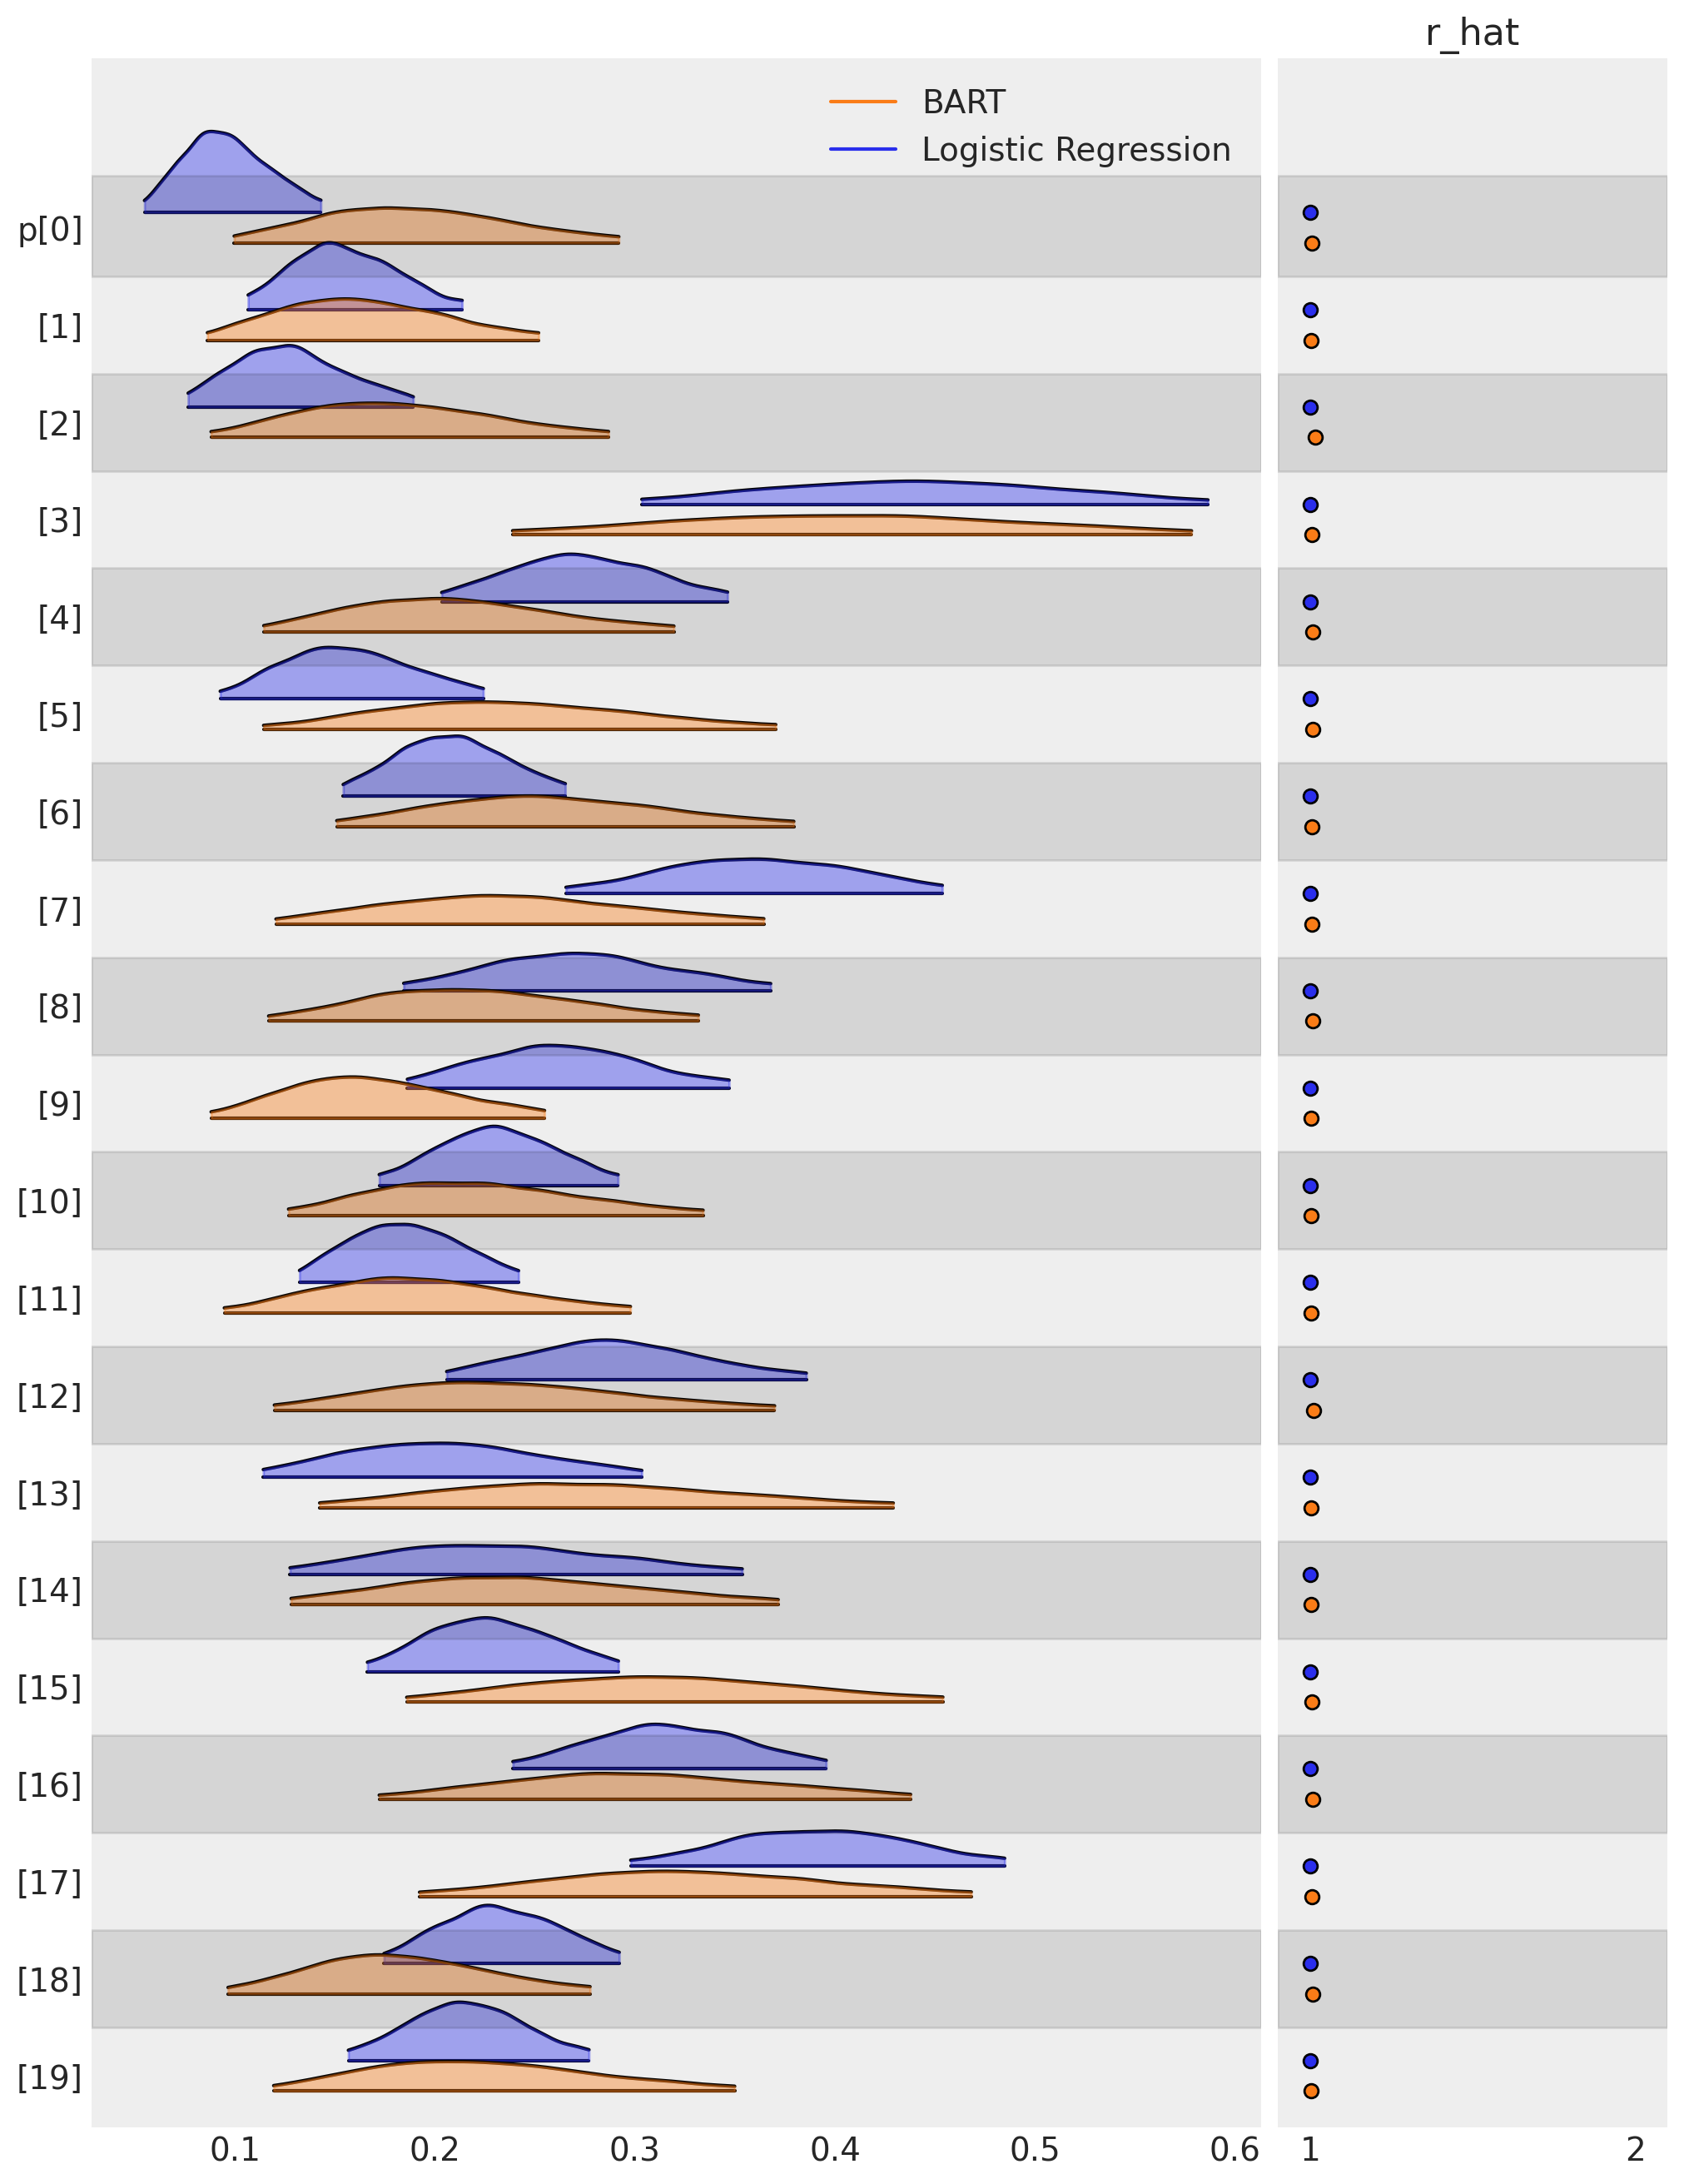

In [10]:
az.plot_forest(
    [idata_logit, idata_probit],
    var_names=["p"],
    coords={"p_dim_0": range(20)},
    figsize=(10, 13),
    combined=True,
    kind="ridgeplot",
    model_names=["Logistic Regression", "BART"],
    r_hat=True,
    ridgeplot_alpha=0.4,
);

These propensity scores can be pulled out and examined alongside the other covariates. But it's probably worth pausing here to explain how and why propensity scores are useful for accounting for selection bias. 

Firstly, and somewhat superficially, the propensity score is a dimension reduction technique. We take a complex covariate profile $X_{i}$ and reduce it to a scaler $p^{i}_{T}(X)$. It is also a tool for thinking about the potential outcomes of an individual under different treatment regimes. In a policy evaluation context it can help partial out the degree of incentives for policy adoption strata of the population. What drives adoption or assignment in the cases of observed data partitioning?

The pivotal idea is that we cannot license causal claims unless (i) the treatment assignment is independent of the covariate profiles i.e $T     \perp\!\!\!\perp X$  and (ii) the outcomes $Y(0)$, and $Y(1)$ and similarly conditionally independent of the treatement $T | X$. If these conditions hold, then we say that $T$ is __strongly ignorable__ given $X$. This also occasionally noted as the __unconfoundedness__ assumption. 

It is a theorem that if $T$ is strongly ignorable given $X$, then (i) and (ii) hold given $p_{T}(X)$ too. So valid statistical inference proceeds in a lower dimensional space using the propensity score as a proxy for the higher dimensional data. There is a great discussion of the details in Aronow and Miller's _Foundations of Agnostic Statistics_ {cite:t}`aronow2019agnostic`. But the insight this suggests is that when you want to estimate a causal effect you are only required to control for the covariates which impact the probability of treatement assignment. More concretely, if it's easier to model the assignment mechanism than the outcome mechanism this can be substituted in the case of causal inference with observed data.

Given the assumption that we are measuring the right covariate profiles to induce __strong ignorability__, then propensity scores can be used thoughtfully to underwrite causal claims. With observational data we cannot re-run the assignment mechanism but we can estimate it, and transform our data to proportionally weight the data summaries within each group so that the analysis is less effected by the over-representation of different strata in each group. This is what we hope to use the propensity scores to achieve. 



In [11]:
ps_logit = idata_logit["posterior"]["p"].mean(dim=("chain", "draw")).round(2)
ps_logit

<xarray.DataArray 'p' (p_dim_0: 1566)>
array([0.1 , 0.16, 0.13, ..., 0.13, 0.47, 0.18])
Coordinates:
  * p_dim_0  (p_dim_0) int64 0 1 2 3 4 5 6 ... 1560 1561 1562 1563 1564 1565

In [12]:
ps_probit = idata_probit["posterior"]["p"].mean(dim=("chain", "draw")).round(2)
ps_probit

<xarray.DataArray 'p' (p_dim_0: 1566)>
array([0.19, 0.17, 0.18, ..., 0.18, 0.38, 0.18])
Coordinates:
  * p_dim_0  (p_dim_0) int64 0 1 2 3 4 5 6 ... 1560 1561 1562 1563 1564 1565

Here we plot the distribution of propensity scores under each model and show how the inverse of the propensity score weights would apply to the observed data points.

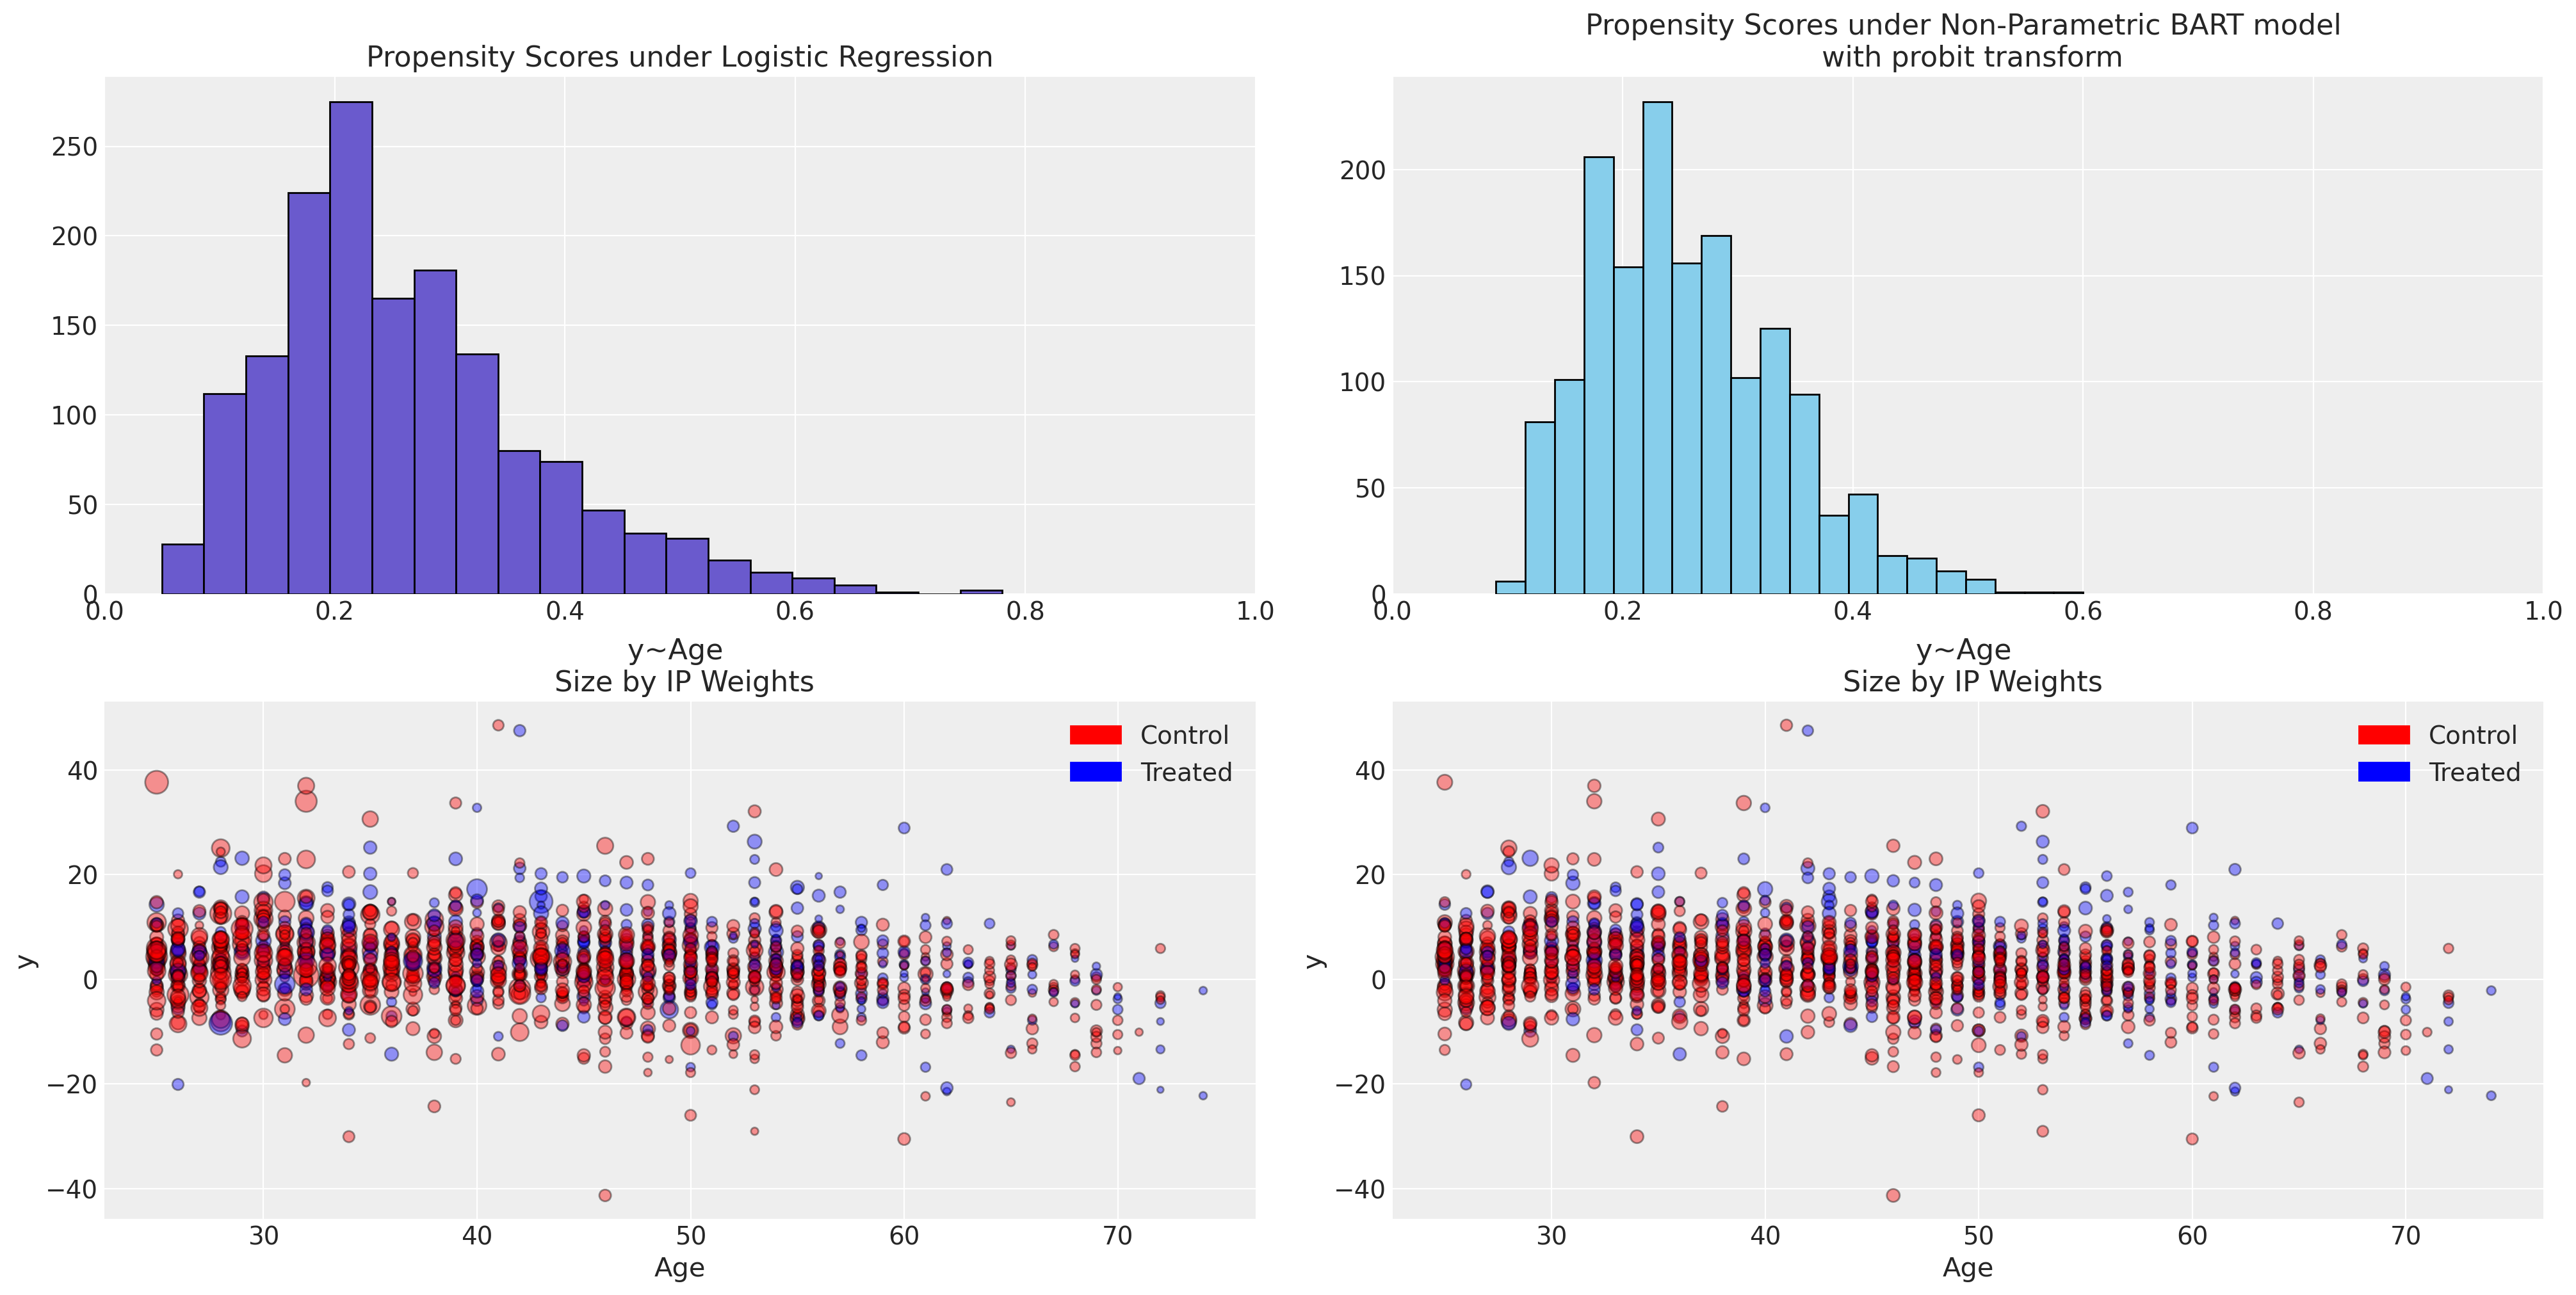

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

colors = {1: "blue", 0: "red"}
axs[0].hist(ps_logit, ec="black", color="slateblue", bins=20)
axs[1].hist(ps_probit, ec="black", color="skyblue", bins=20)
axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)
axs[0].set_title("Propensity Scores under Logistic Regression")
axs[1].set_title("Propensity Scores under Non-Parametric BART model \n with probit transform")
axs[2].scatter(
    X["age"], y, color=t.map(colors), s=(1 / ps_logit.values) * 10, ec="black", alpha=0.4
)
axs[2].set_xlabel("Age")
axs[3].set_xlabel("Age")
axs[3].set_ylabel("y")
axs[2].set_ylabel("y")
axs[2].set_title("y~Age \n Size by IP Weights")
axs[3].set_title("y~Age \n Size by IP Weights")
axs[3].scatter(
    X["age"], y, color=t.map(colors), s=(1 / ps_probit.values) * 10, ec="black", alpha=0.4
)
red_patch = mpatches.Patch(color="red", label="Control")
blue_patch = mpatches.Patch(color="blue", label="Treated")
axs[2].legend(handles=[red_patch, blue_patch])
axs[3].legend(handles=[red_patch, blue_patch]);

These weighting schemes can now be incorporated into various models of statistical summaries so as to "correct" the representation of covariate profiles across both groups. If an individual's propensity score is such that they are are highly likely to receive the treatment status e.g .95 then we want to downweight their importance if they occur in the treatment and upweight their importance if they appear in the control group. This makes sense because their high propensity score implies that similar individuals are already heavily present in the treatment group, but less likely to occur in the control group. Hence our corrective strategy re-weights their contribution to the summary statistics across each group. 

### Robust and Doubly Robust Propensity Scores

We've been keen to stress that propensity based weights are a corrective. An opportunity for the causal analyst to put their finger on the scale and adjust the representative shares accorded to individuals in the treatment and control groups. Yet, there are no universal correctives, and naturally a variety of alternatives have arisen to fill gaps where simple propensity score weighting fails. We will see below a number of alternative weighting schemes. 

The main distinction to call out is between the raw propensity score weights and the doubly-robust theory of propensity score weights. 

Doubly robust methods, so named because they represent a compromise estimator for causal effect that combines (i) a treatment assignment model (like propensity scores) and (ii) a more direct response outcome model. The method combines these two estimators in a way to generate a statistically unbiased estimate of the treatment effect. They work well because the way they are combined requires that only one of the models needs to be well-specified. The analyst chooses the components of their weighting scheme in so far as they believe they have correctly modelled either (i) or (ii). 

## Estimated Expected Causal Effect (ATE)

The next code block builds a set of functions to pull out an extract a sample from our posterior distribution of propensity scores and use this propensity score to reweight the observed outcome variable across our treatment and control groups to re-calculate the average treatment effect (ATE). It reweights our data using the inverse probability weighting scheme and then plots three views (1) the raw propensity scores across groups (2) the raw outcome distribution and (3) the re-weighted outcome distribution. 



In [14]:
def plot_weights(bins, top0, top1, ylim, ax):
    ax.axhline(0, c="gray", linewidth=1)
    ax.set_ylim(ylim)
    bars0 = ax.bar(bins[:-1] + 0.025, top0, width=0.04, facecolor="red", alpha=0.4)
    bars1 = ax.bar(bins[:-1] + 0.025, -top1, width=0.04, facecolor="blue", alpha=0.4)

    for bars in (bars0, bars1):
        for bar in bars:
            bar.set_edgecolor("black")

    for x, y in zip(bins, top0):
        ax.text(x + 0.025, y + 10, str(y), ha="center", va="bottom")

    for x, y in zip(bins, top1):
        ax.text(x + 0.025, -y - 10, str(y), ha="center", va="top")


def make_plot(
    X,
    idata,
    lower_bins=np.arange(1, 30, 1),
    ylims=[
        (-100, 370),
        (
            -40,
            100,
        ),
        (-50, 110),
    ],
    text_pos=(20, 80),
    ps=None,
    method="robust",
):
    X = X.copy()
    if ps is None:
        n_list = list(range(1000))
        ## Choose random ps score from posterior
        choice = np.random.choice(n_list, 1)[0]
        X["ps"] = idata["posterior"]["p"].stack(z=("chain", "draw"))[:, choice].values
    else:
        X["ps"] = ps
    X["trt"] = t
    propensity0 = X[X["trt"] == 0]["ps"]
    propensity1 = X[X["trt"] == 1]["ps"]
    if method == "robust":
        p_of_t = X["trt"].mean()
        X["i_ps"] = np.where(t, (p_of_t / X["ps"]), (1 - p_of_t) / (1 - X["ps"]))
        n_ntrt = X[X["trt"] == 0].shape[0]
        n_trt = X[X["trt"] == 1].shape[0]
    elif method == "raw":
        X["ps"] = np.where(X["trt"], X["ps"], 1 - X["ps"])
        X["i_ps"] = 1 / X["ps"]
        n_ntrt = n_trt = len(X)
    else:
        m0 = sm.OLS(y[t == 0], X[t == 0]).fit()
        m1 = sm.OLS(y[t == 1], X[t == 1]).fit()
        m0_pred = m0.predict(X)
        m1_pred = m0.predict(X)
        X["trt"] = t
        X["y"] = y
        p_of_t = X["trt"].mean()
        X["i_ps"] = np.where(t, (p_of_t / X["ps"]), (1 - p_of_t) / (1 - X["ps"]))

        weighted_outcome0 = (1 - X["trt"]) * (X["y"] - m0_pred) / (1 - X["ps"]) + m0_pred
        weighted_outcome1 = X["trt"] * (X["y"] - m1_pred) / X["ps"] + m1_pred
    X["outcome"] = y

    bins = np.arange(0.025, 0.85, 0.05)
    top0, _ = np.histogram(propensity0, bins=bins)
    top1, _ = np.histogram(propensity1, bins=bins)

    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    axs = axs.flatten()

    plot_weights(bins, top0, top1, ylims[0], axs[0])
    axs[0].text(0.05, 230, "Control = 0")
    axs[0].text(0.05, -90, "Treatment = 1")

    axs[0].set_ylabel("No. Patients", fontsize=14)
    axs[0].set_xlabel("Estimated Propensity Score", fontsize=14)
    axs[0].set_title(
        "Inferred Propensity Scores and IP Weighted Outcome \n by Treatment and Control",
        fontsize=20,
    )

    bins = lower_bins

    outcome_trt = X[X["trt"] == 1]["outcome"]
    outcome_ntrt = X[X["trt"] == 0]["outcome"]
    i_propensity0 = X[X["trt"] == 0]["i_ps"]
    i_propensity1 = X[X["trt"] == 1]["i_ps"]

    axs[2].set_ylabel("No. Patients", fontsize=14)
    if method in ["raw", "robust"]:
        weighted_outcome1 = outcome_trt * i_propensity1
        weighted_outcome0 = outcome_ntrt * i_propensity0
        top0, _ = np.histogram(weighted_outcome0, bins=bins)
        top1, _ = np.histogram(weighted_outcome1, bins=bins)
        plot_weights(bins, top0, top1, ylims[1], axs[2])
        axs[2].set_xlabel("Estimated IP Weighted Outcome \n Shifted", fontsize=14)
        axs[2].text(text_pos[0], text_pos[1], f"Control: E(Y) = {weighted_outcome0.sum() / n_ntrt}")
        axs[2].text(
            text_pos[0], text_pos[1] - 20, f"Treatment: E(Y) = {weighted_outcome1.sum() / n_trt}"
        )
        axs[2].text(
            text_pos[0],
            text_pos[1] - 40,
            f"tau: E(Y(1) - Y(0)) = {weighted_outcome0.sum() / n_ntrt - weighted_outcome1.sum() / n_trt}",
        )
    else:
        top0, _ = np.histogram(weighted_outcome0, bins=bins)
        top1, _ = np.histogram(weighted_outcome1, bins=bins)
        plot_weights(bins, top0, top1, ylims[1], axs[2])
        trt = np.mean(X["trt"] * (X["y"] - m1_pred) / X["ps"] + m1_pred)
        ntrt = np.mean((1 - X["trt"]) * (X["y"] - m0_pred) / (1 - X["ps"]) + m0_pred)
        axs[2].set_xlabel("Estimated IP Weighted Outcome \n Shifted", fontsize=14)
        axs[2].text(text_pos[0], text_pos[1], f"Control: E(Y) = {ntrt}")
        axs[2].text(text_pos[0], text_pos[1] - 20, f"Treatment: E(Y) = {trt}")
        axs[2].text(
            text_pos[0],
            text_pos[1] - 40,
            f"tau: E(Y(1) - Y(0)) = {ntrt - trt}",
        )

    top0, _ = np.histogram(outcome_ntrt, bins=bins)
    top1, _ = np.histogram(outcome_trt, bins=bins)
    plot_weights(bins, top0, top1, ylims[2], axs[1])
    axs[1].set_ylabel("No. Patients", fontsize=14)
    axs[1].set_xlabel("Raw Outcome Measure", fontsize=14)
    axs[1].text(text_pos[0], text_pos[1], f"Control: E(Y) = {outcome_ntrt.mean()}")
    axs[1].text(text_pos[0], text_pos[1] - 20, f"Treatment: E(Y) = {outcome_trt.mean()}")
    axs[1].text(
        text_pos[0],
        text_pos[1] - 40,
        f"tau: E(Y(1) - Y(0)) = {outcome_trt.mean() - outcome_ntrt.mean()}",
    )

## The Logit Propensity Model

We plot the outcome and re-weighted outcome distribution using the robust propensity score estimation method.

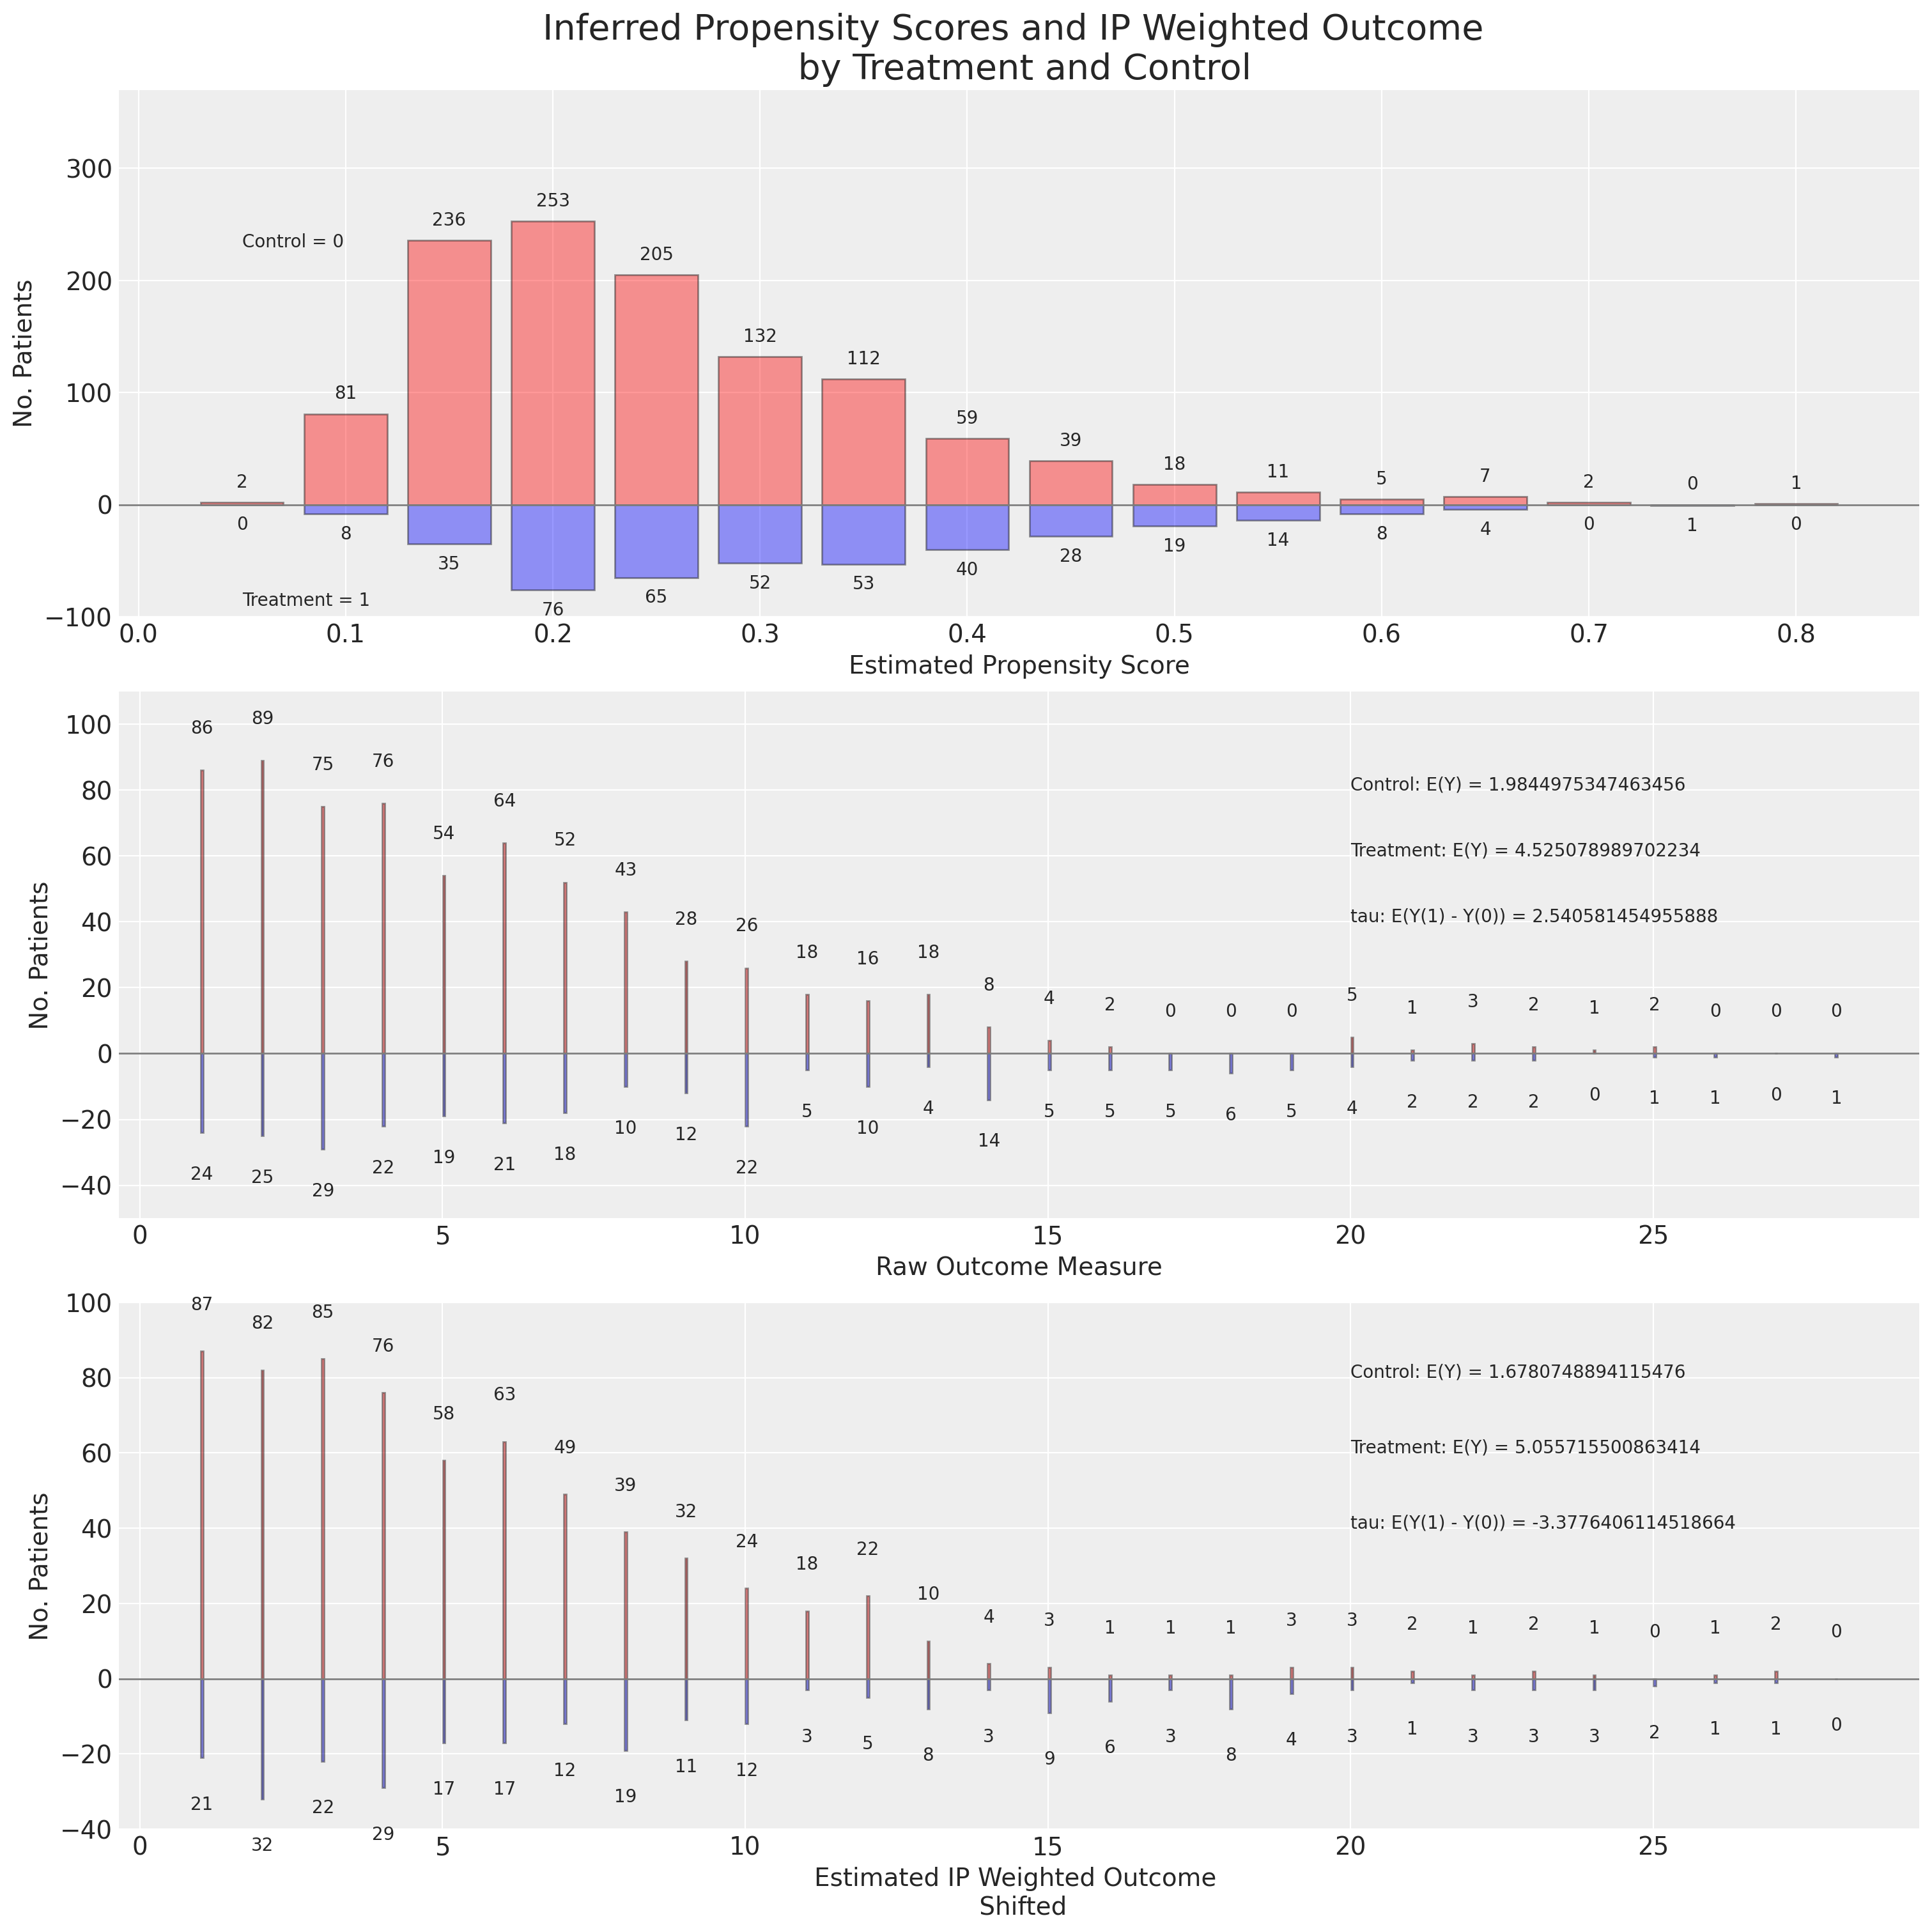

In [15]:
make_plot(X, idata_logit, method="robust")

Next, and because we are Bayesians - we pull out and evaluate the posterior distribution of the ATE basd on the sampled propensity scores. We've seen a point estimate for the ATE above, but it's often more important in the causal inference context to understand the uncertainty in the estimate. 

In [16]:
def get_ate(X, t, y, i, idata, method="doubly_robust"):
    X = X.copy()
    X["ps"] = idata["posterior"]["p"].stack(z=("chain", "draw"))[:, i].values
    if method == "robust":
        X["trt"] = t
        p_of_t = X["trt"].mean()
        X["i_ps"] = np.where(t, (p_of_t / X["ps"]), (1 - p_of_t) / (1 - X["ps"]))
        i_propensity0 = X[X["trt"] == 0]["i_ps"]
        i_propensity1 = X[X["trt"] == 1]["i_ps"]
    elif method == "raw":
        X["trt"] = t
        X["ps"] = np.where(X["trt"], X["ps"], 1 - X["ps"])
        X["i_ps"] = 1 / X["ps"]
        i_propensity0 = X[X["trt"] == 0]["i_ps"]
        i_propensity1 = X[X["trt"] == 1]["i_ps"]
    else:
        ## model estimates of Doubly robust method
        m0 = sm.OLS(y[t == 0], X[t == 0]).fit()
        m1 = sm.OLS(y[t == 1], X[t == 1]).fit()
        m0_pred = m0.predict(X)
        m1_pred = m0.predict(X)
        X["trt"] = t
        X["y"] = y
    X["outcome"] = y
    outcome_trt = X[X["trt"] == 1]["outcome"]
    outcome_ntrt = X[X["trt"] == 0]["outcome"]
    if method == "robust":
        weighted_outcome_ntrt = i_propensity0 * outcome_ntrt
        weighted_outcome_trt = i_propensity1 * outcome_trt
        ntrt = weighted_outcome_ntrt.sum() / len(X[X["trt"] == 0])
        trt = weighted_outcome_trt.sum() / len(X[X["trt"] == 1])
    elif method == "raw":
        weighted_outcome_ntrt = i_propensity0 * outcome_ntrt
        weighted_outcome_trt = i_propensity1 * outcome_trt
        ntrt = weighted_outcome_ntrt.sum() / len(X)
        trt = weighted_outcome_trt.sum() / len(X)
    else:
        ## Compromise step between assignment model and outcome model
        ## Model mispecification forces the terms towards zero cancelling
        ## out misspecification.
        trt = np.mean(X["trt"] * (X["y"] - m1_pred) / X["ps"] + m1_pred)
        ntrt = np.mean((1 - X["trt"]) * (X["y"] - m0_pred) / (1 - X["ps"]) + m0_pred)
    ate = ntrt - trt
    return [ate, trt, ntrt]


qs = range(4000)
ate_dist = [get_ate(X, t, y, q, idata_logit, method="robust") for q in qs]

ate_dist_df_logit = pd.DataFrame(ate_dist, columns=["ATE", "E(Y(1))", "E(Y(0))"])
ate_dist_df_logit.head()

ATE   E(Y(1))   E(Y(0))
0 -3.661868  5.430557  1.768689
1 -3.223982  5.070464  1.846481
2 -3.387904  5.159992  1.772087
3 -4.316006  6.034640  1.718635
4 -4.049790  5.746255  1.696465

Next we plot the posterior distribution of the ATE. 

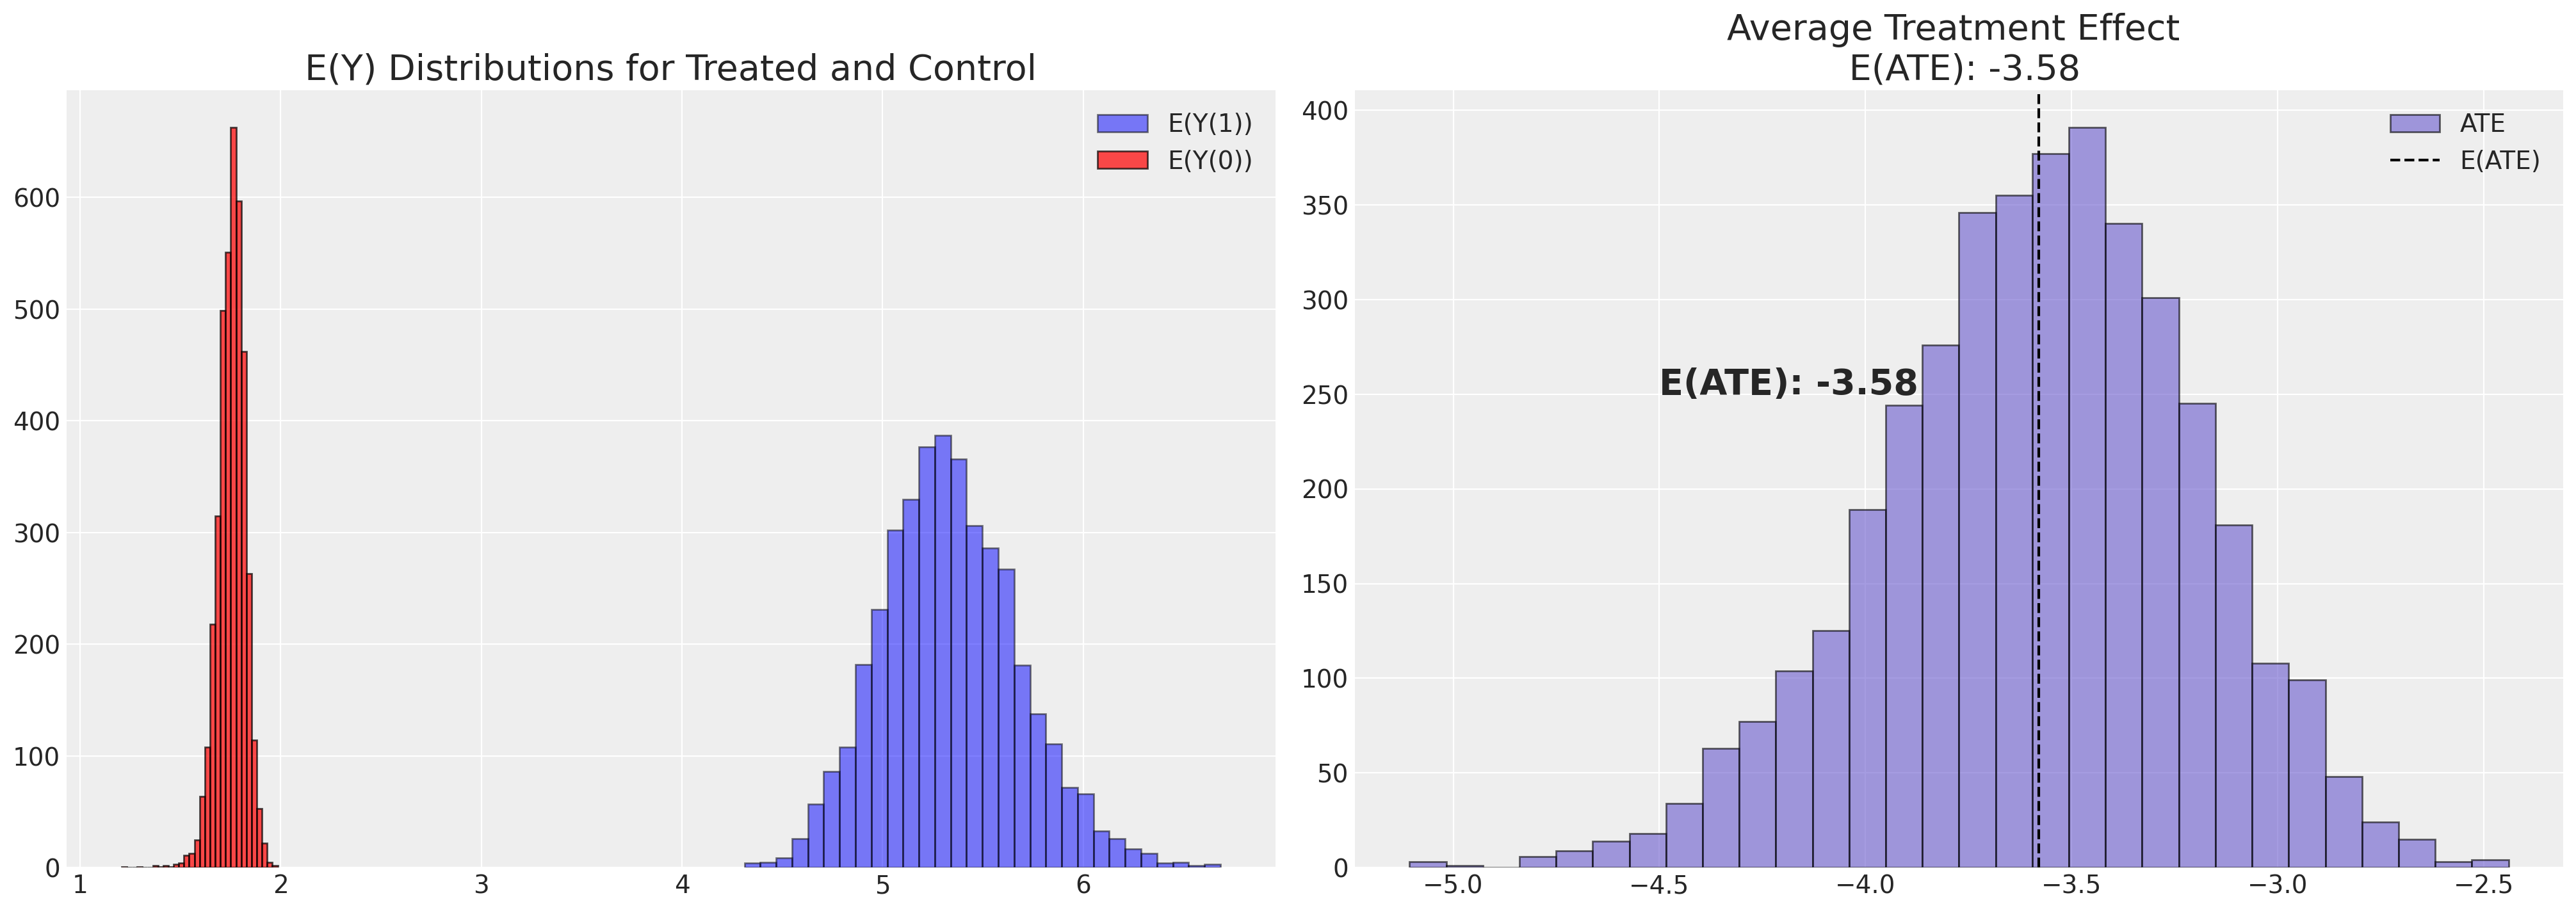

In [17]:
def plot_ate(ate_dist_df, xy=(-4.5, 250)):
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs = axs.flatten()
    axs[0].hist(
        ate_dist_df["E(Y(1))"], bins=30, ec="black", color="blue", label="E(Y(1))", alpha=0.5
    )
    axs[0].hist(
        ate_dist_df["E(Y(0))"], bins=30, ec="black", color="red", label="E(Y(0))", alpha=0.7
    )
    axs[1].hist(ate_dist_df["ATE"], bins=30, ec="black", color="slateblue", label="ATE", alpha=0.6)
    ate = np.round(ate_dist_df["ATE"].mean(), 2)
    axs[1].axvline(ate, label="E(ATE)", linestyle="--", color="black")
    axs[1].annotate(f"E(ATE): {ate}", xy, fontsize=20, fontweight="bold")
    axs[1].set_title(f"Average Treatment Effect \n E(ATE): {ate}", fontsize=20)
    axs[0].set_title("E(Y) Distributions for Treated and Control", fontsize=20)
    axs[1].legend()
    axs[0].legend()


plot_ate(ate_dist_df_logit)

Note how this estimate of the treatment effect quite different than what we got taking the simple difference of averages across groups. 

## The BART Propensity Model

Next we'll apply the doubly robust estimator to the propensity distribution achieved using the BART non-parametric model.

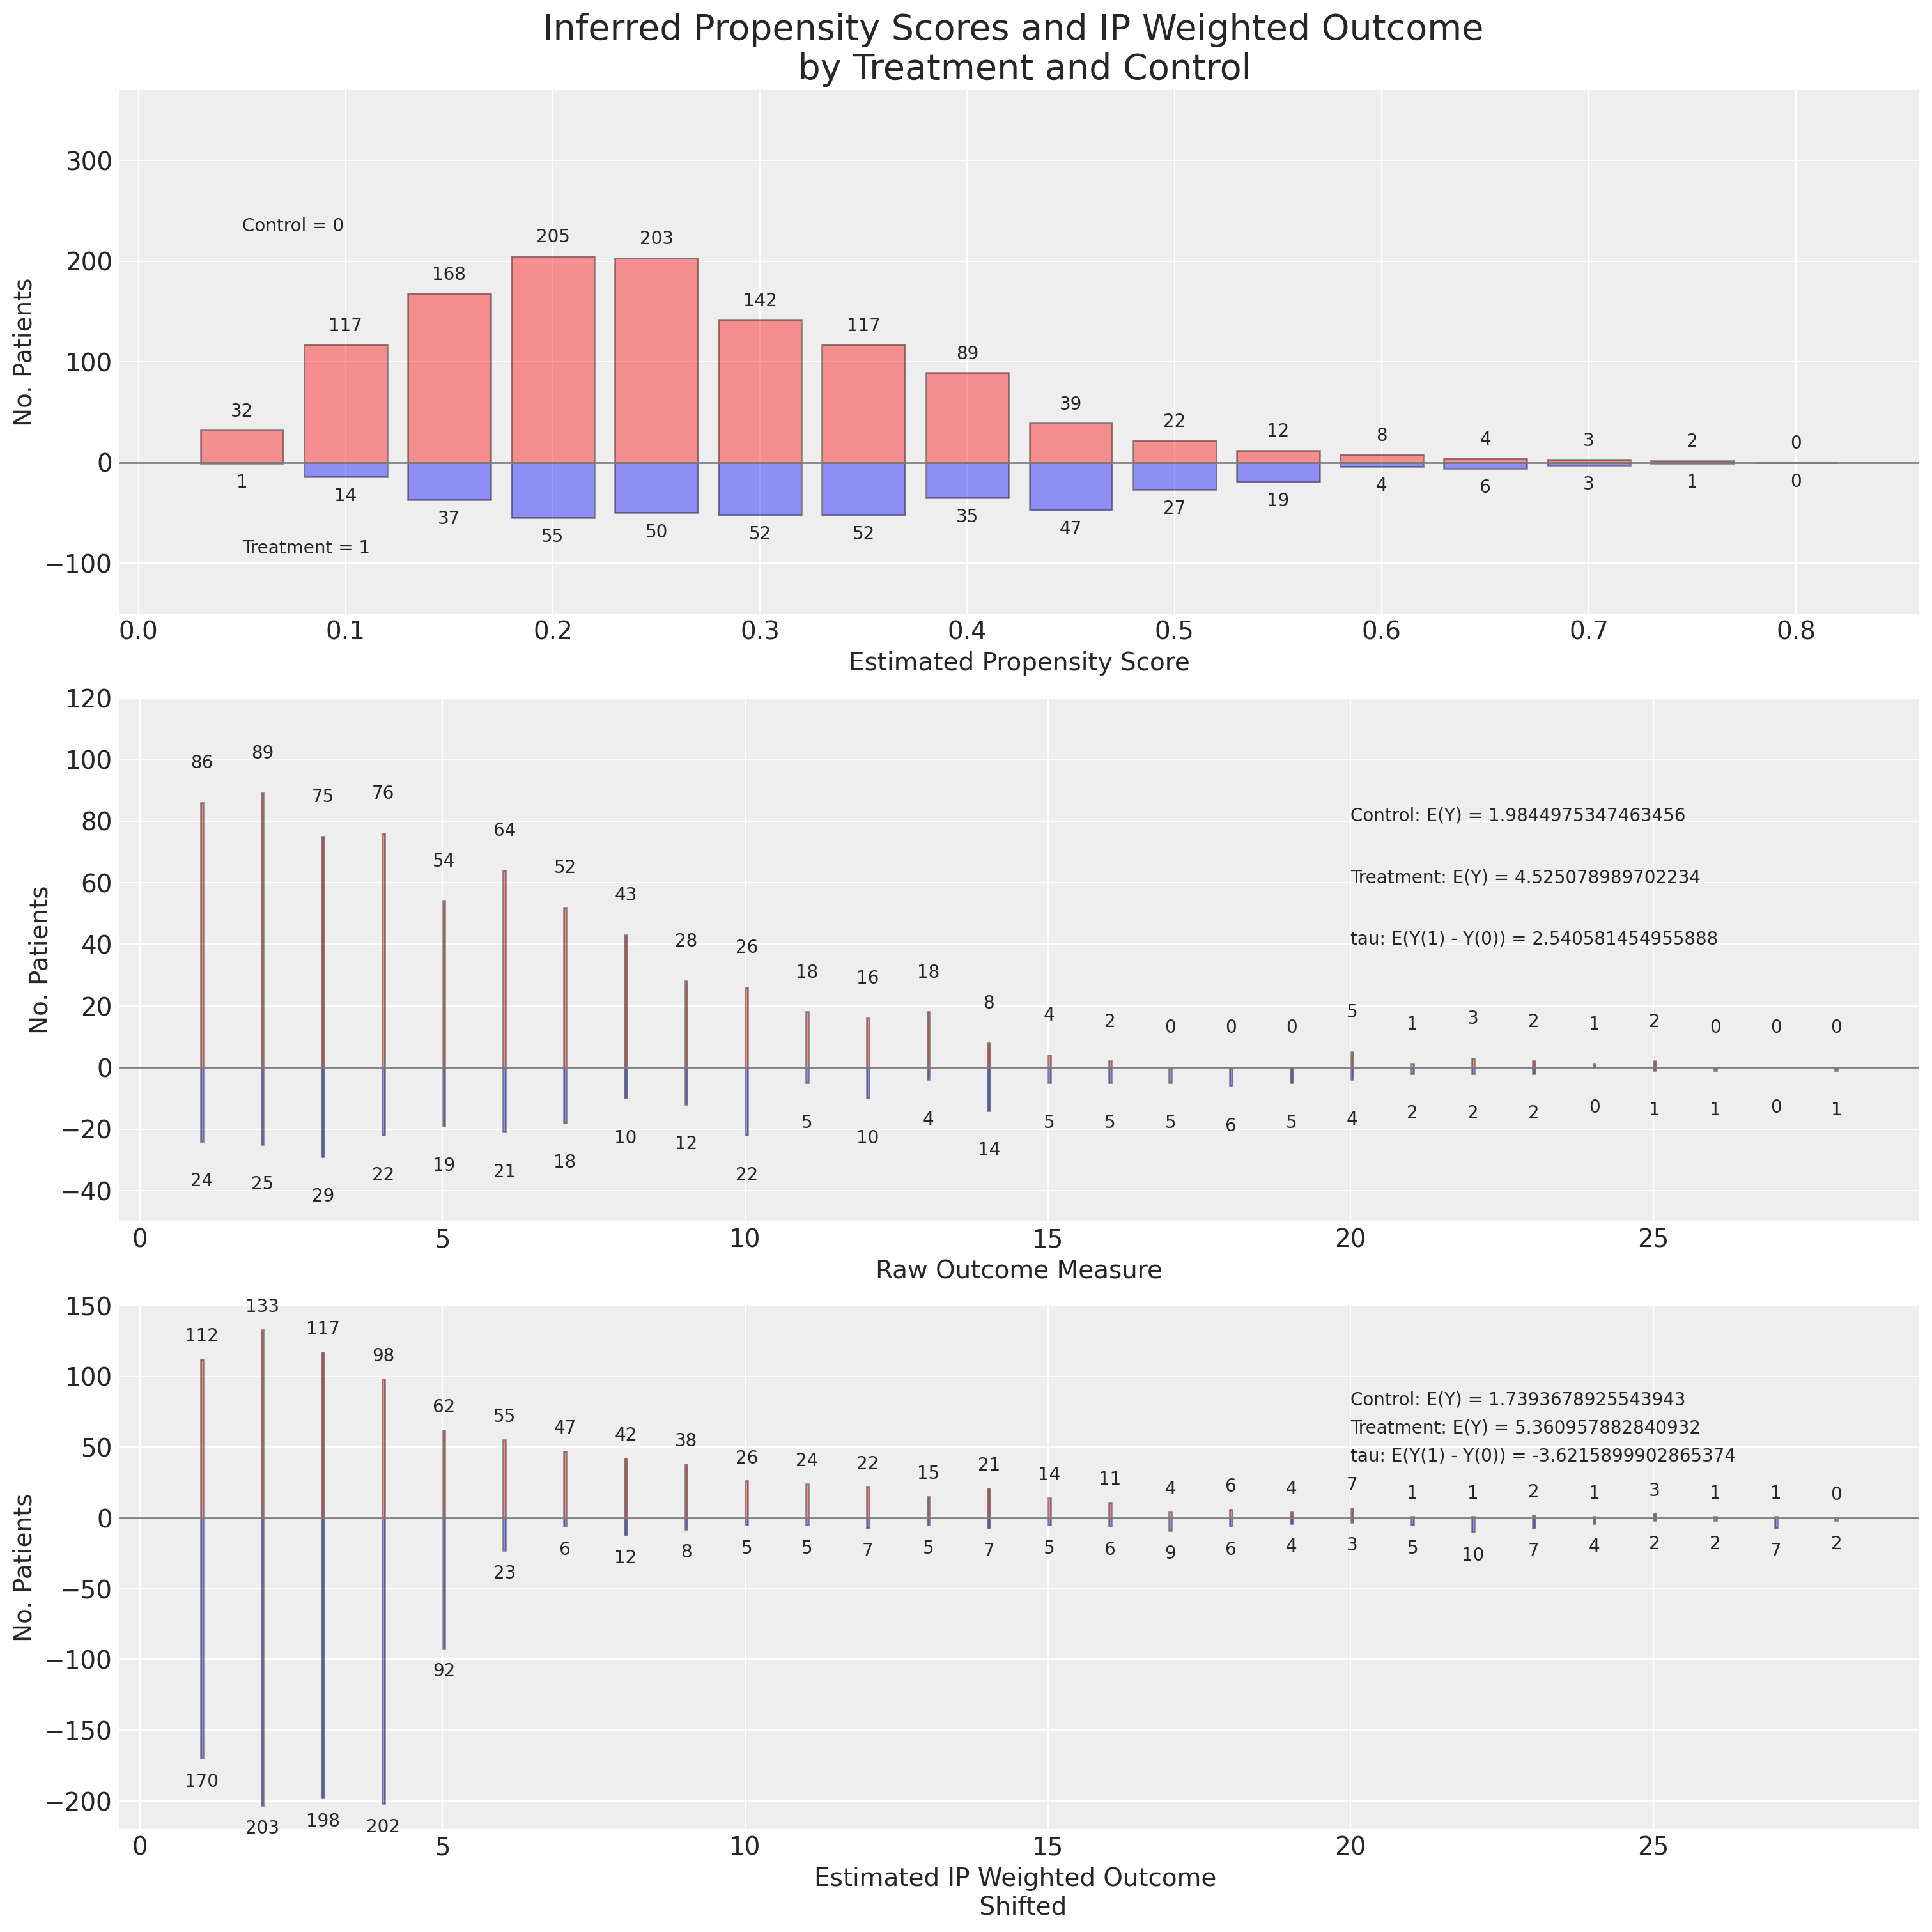

In [18]:
make_plot(X, idata_probit, method="doubly_robust", ylims=[(-150, 370), (-220, 150), (-50, 120)])

In [19]:
ate_dist_probit = [get_ate(X, t, y, q, idata_probit, method="doubly_robust") for q in qs]
ate_dist_df_probit = pd.DataFrame(ate_dist_probit, columns=["ATE", "E(Y(1))", "E(Y(0))"])
ate_dist_df_probit.head()

ATE   E(Y(1))   E(Y(0))
0 -3.644938  5.402516  1.757578
1 -3.532540  5.274941  1.742400
2 -3.234675  4.979683  1.745007
3 -3.780732  5.520388  1.739656
4 -3.640441  5.397788  1.757347

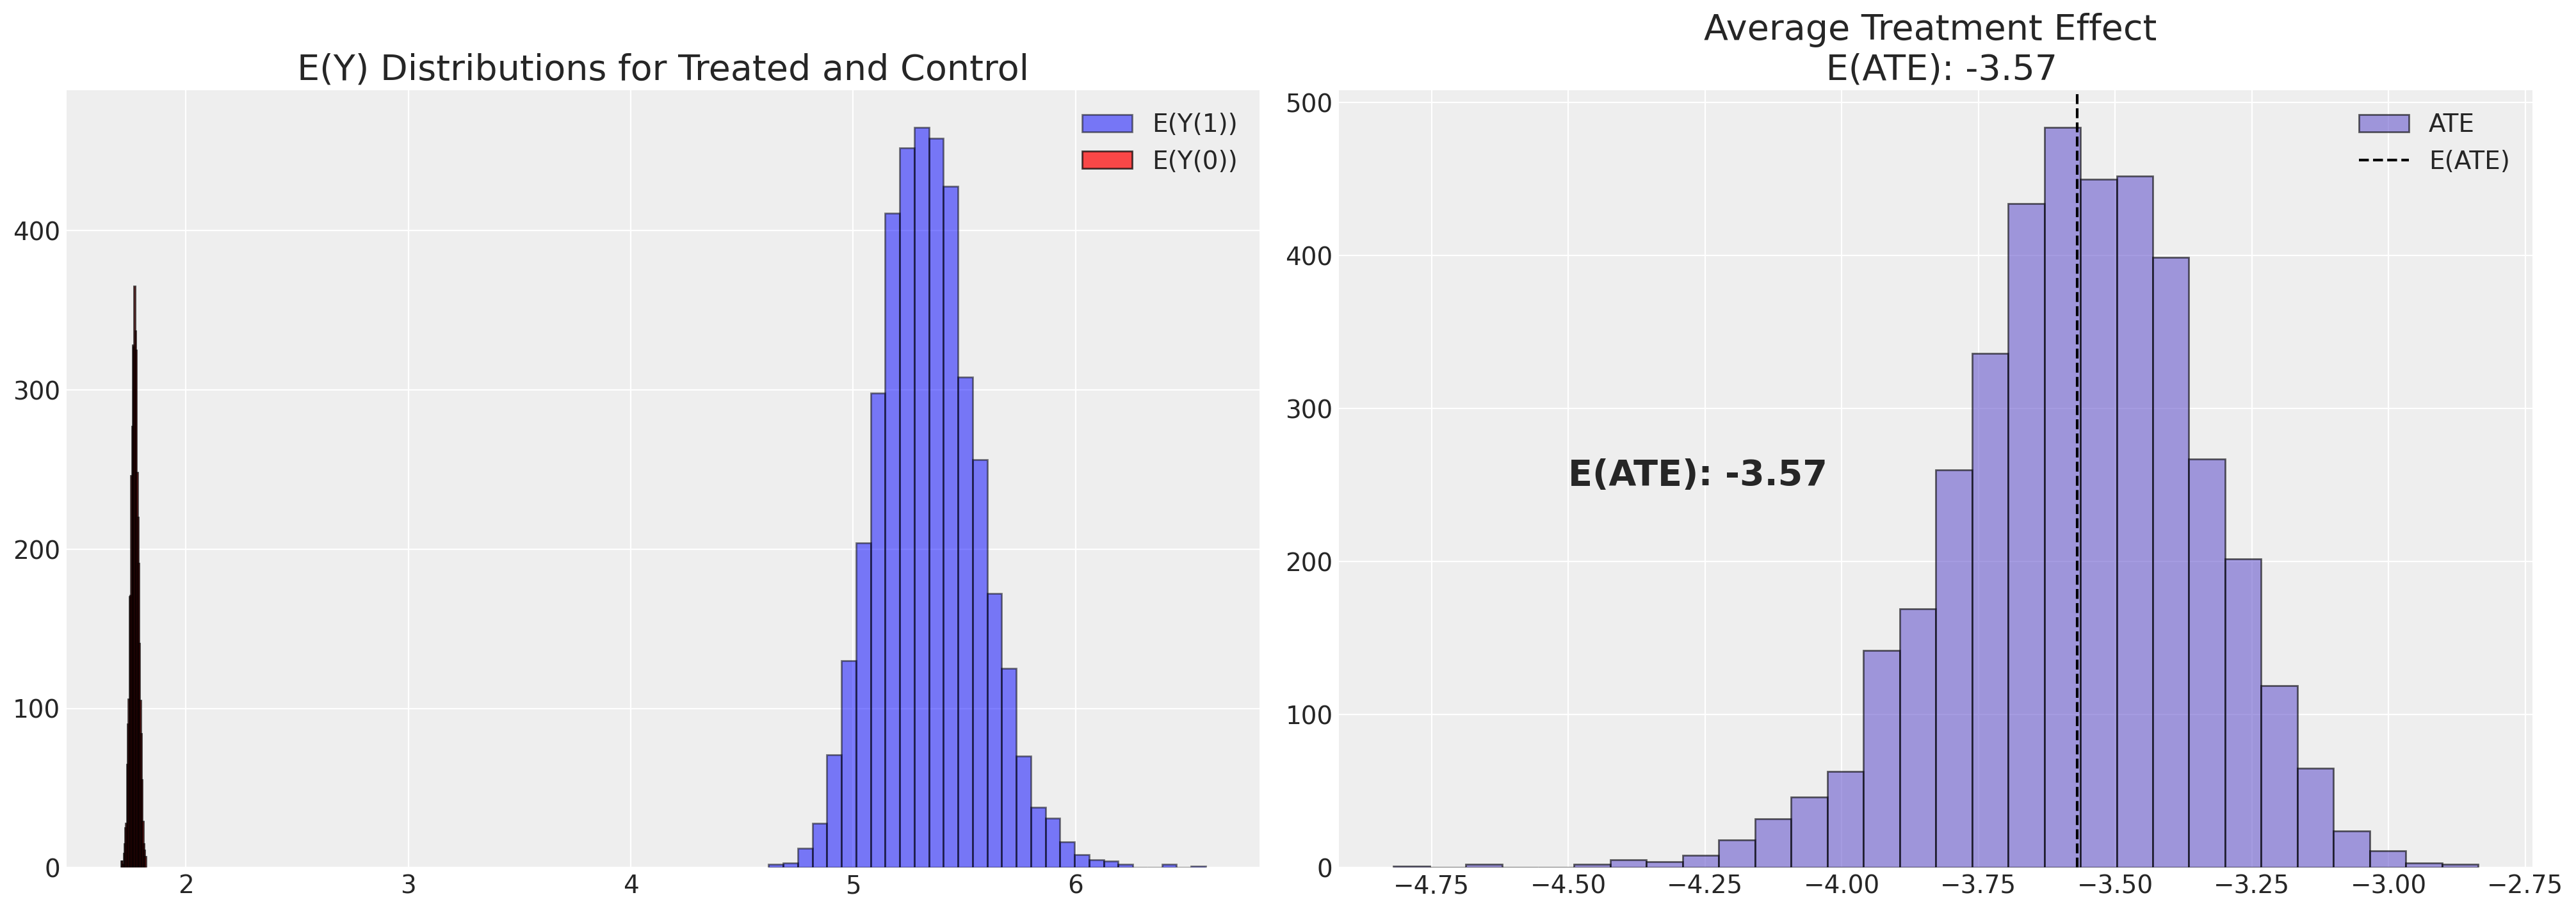

In [20]:
plot_ate(ate_dist_df_probit)

Note the tighter variance of the measures using the doubly robust method. 

### Considerations Choosing between models

It is one thing to evalute change in average over the population, but we might want to allow for the idea of effect heterogenity across the population and as such the BART model is generally better at ensuring accurate predictions acros the deepter strata of our data. But the flexibility of machine learning models for prediction tasks do not guarantee that the propensity scores attributed across the sample are well calibrated to recover the true-treatment effects when used in causal effect estimation. We have to be careful in how we use the flexibility of non-parametric models in the causal context. 

First observe the hetereogenous accuracy induced by the BART model across increasingly narrow strata of our sample. 

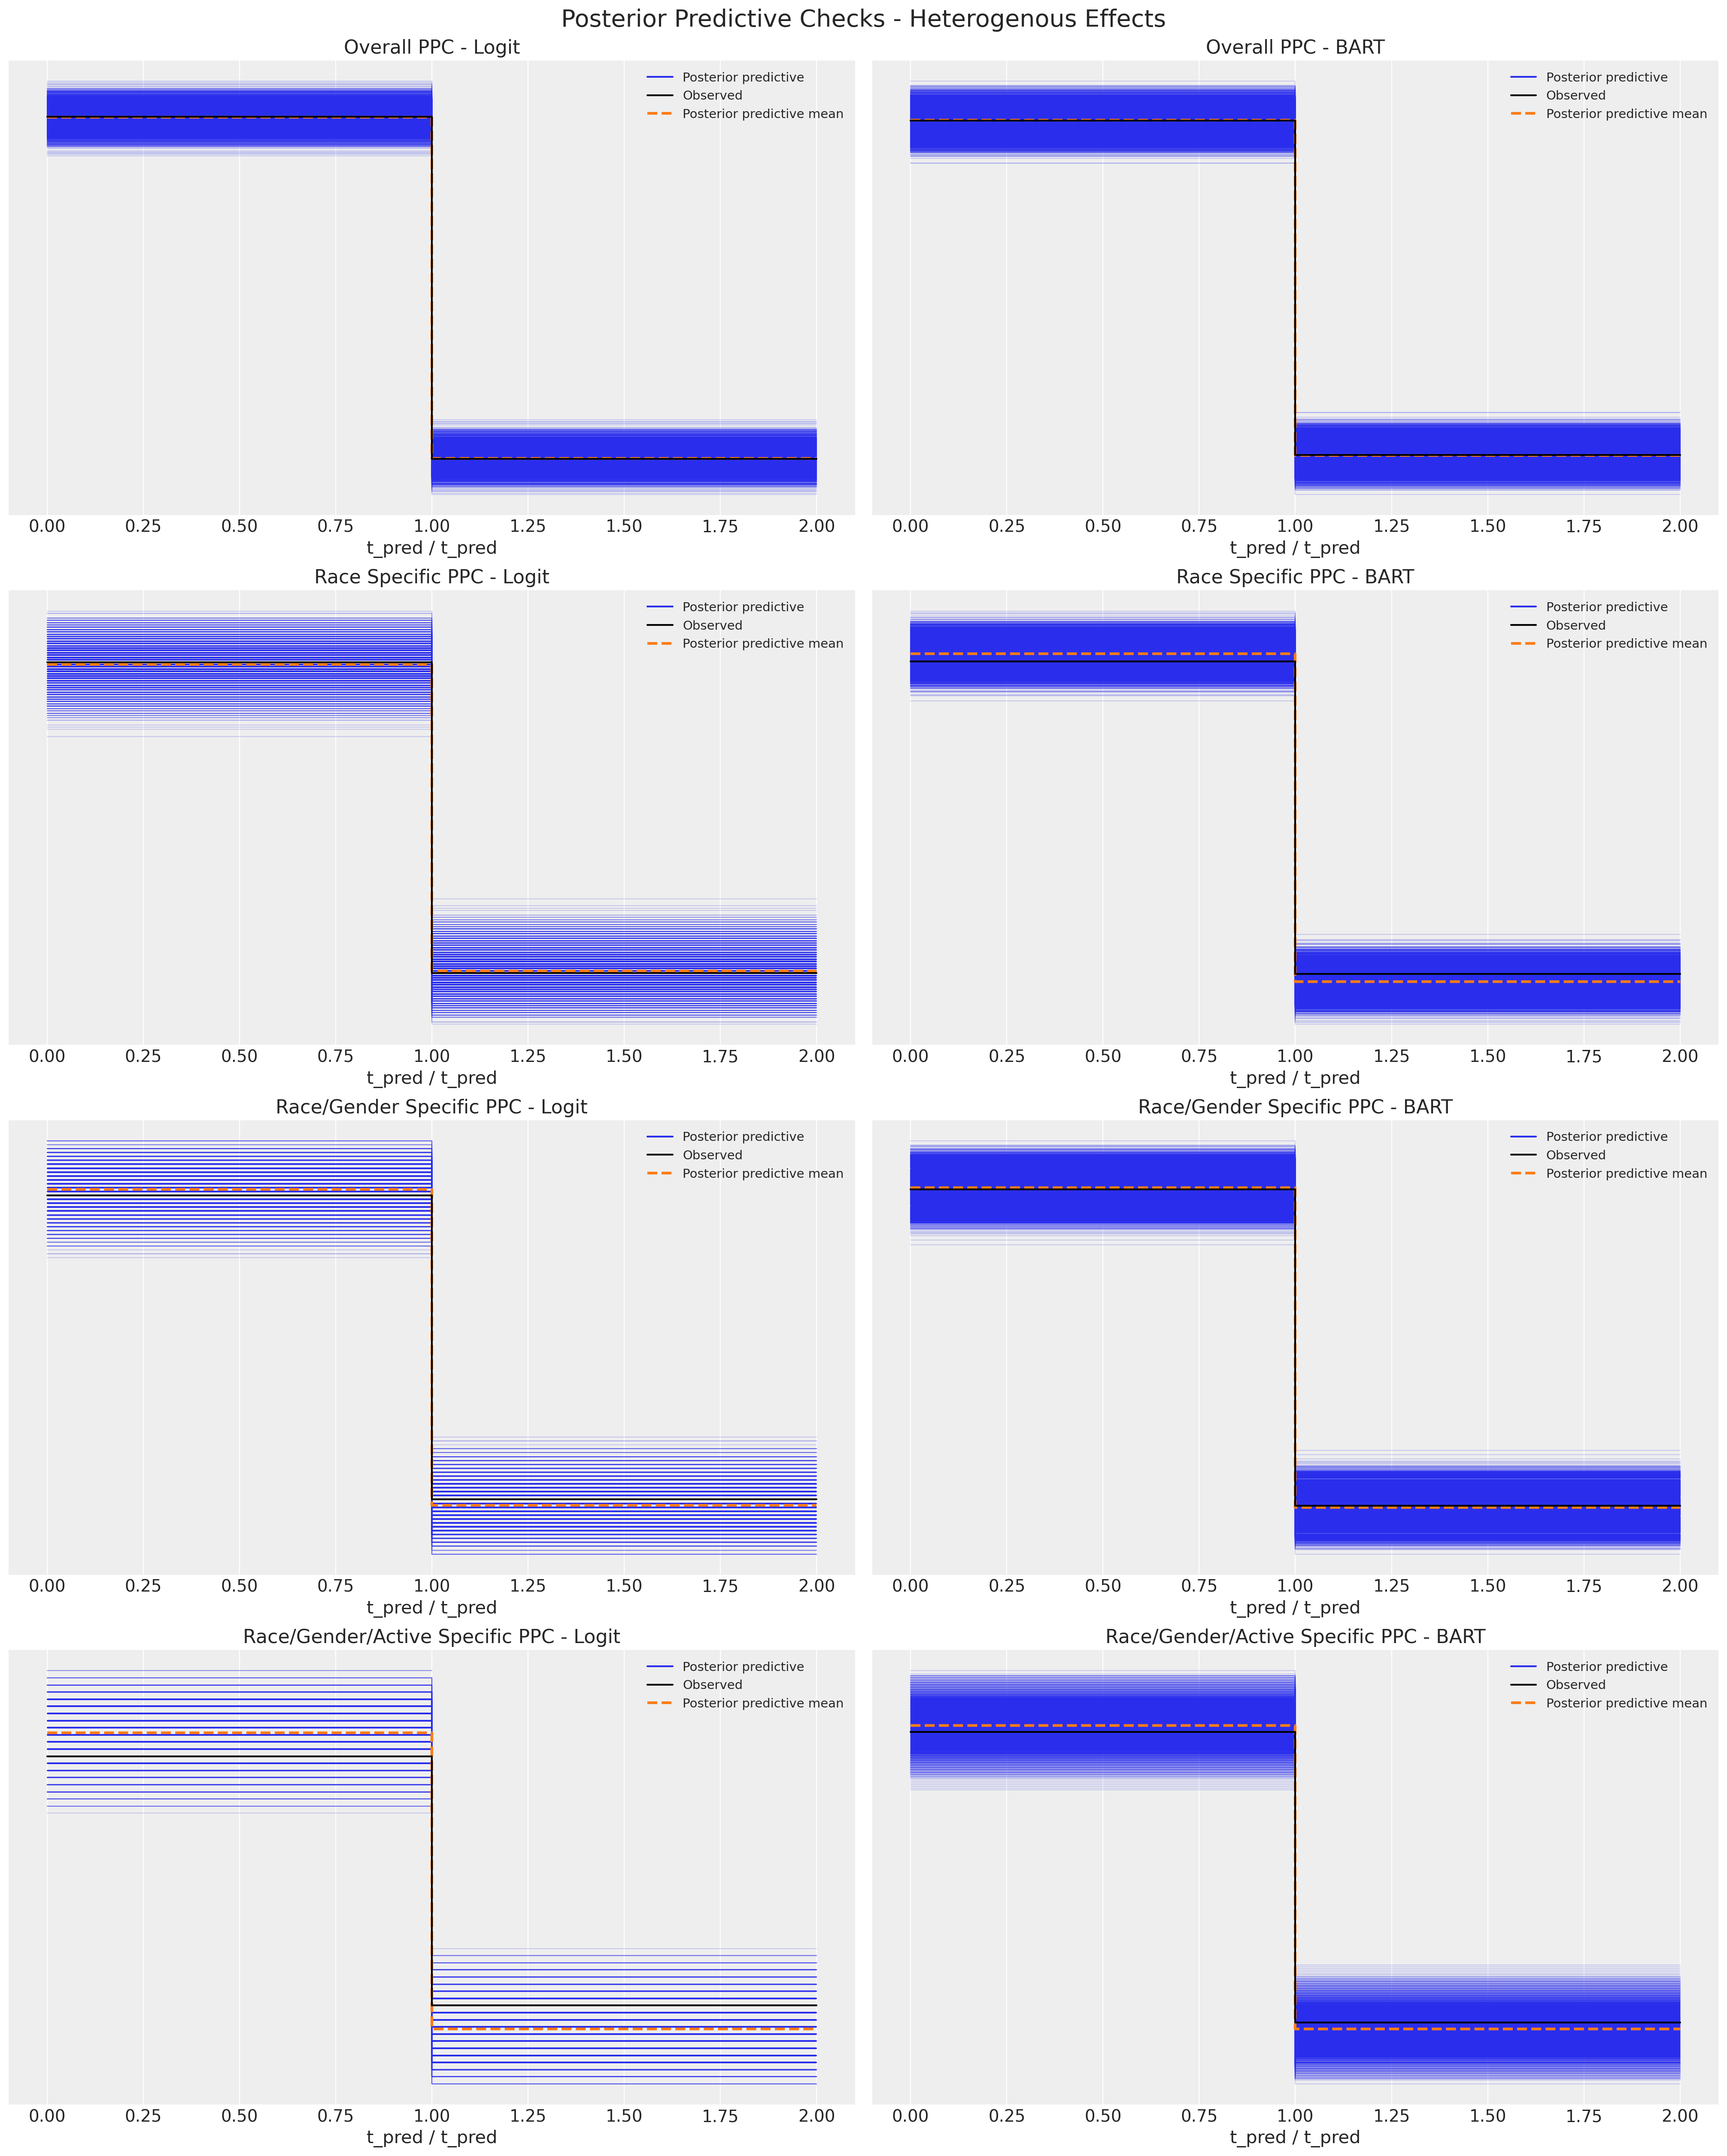

In [21]:
fig, axs = plt.subplots(4, 2, figsize=(20, 25))
axs = axs.flatten()
az.plot_ppc(idata_logit, ax=axs[0])
az.plot_ppc(idata_probit, ax=axs[1])
idx1 = list((X[X["race"] == 1].index).values)
idx0 = list((X[X["race"] == 0].index).values)
az.plot_ppc(idata_logit, ax=axs[2], coords={"obs": idx1})
az.plot_ppc(idata_probit, ax=axs[3], coords={"obs": idx0})
idx1 = list((X[(X["race"] == 1) & (X["sex"] == 1)].index).values)
idx0 = list((X[(X["race"] == 0) & (X["sex"] == 1)].index).values)
az.plot_ppc(idata_logit, ax=axs[4], coords={"obs": idx1})
az.plot_ppc(idata_probit, ax=axs[5], coords={"obs": idx0})
idx1 = list((X[(X["race"] == 1) & (X["sex"] == 1) & (X["active_1"] == 1)].index).values)
idx0 = list((X[(X["race"] == 0) & (X["sex"] == 1) & (X["active_1"] == 1)].index).values)
az.plot_ppc(idata_logit, ax=axs[6], coords={"obs": idx1})
az.plot_ppc(idata_probit, ax=axs[7], coords={"obs": idx0})
axs[0].set_title("Overall PPC - Logit")
axs[1].set_title("Overall PPC - BART")
axs[2].set_title("Race Specific PPC - Logit")
axs[3].set_title("Race Specific PPC - BART")
axs[4].set_title("Race/Gender Specific PPC - Logit")
axs[5].set_title("Race/Gender Specific PPC - BART")
axs[6].set_title("Race/Gender/Active Specific PPC - Logit")
axs[7].set_title("Race/Gender/Active Specific PPC - BART")
plt.suptitle("Posterior Predictive Checks - Heterogenous Effects", fontsize=20);

Observations like this go along way to motivating the use of flexible machine learning methods in causal inference. The model used to capture the outcome distribution or the propensity score distribution ought to be sensetive to variation across extremities of the data. We can see above that the predictive power of the simpler logistic regression model deterioriates as we progress down the partitions of the data. We will see an example below where this flexibility becomes a problem and how it can be fixed. 

### Regression with Propensity Scores

Another perhaps more direct method of causal inference is to just use regression directly. Angrist and Pischke suggest that the familiar properties of regression make it more desirable, but concede that there is a role for propensity and that the methods can be combined by the cautious analyst. Here we'll show how we can combine the propensity score in a regression context to derive estimates of treatment effects. 


In [22]:
def make_prop_reg_model(X, t, y, idata_ps, covariates=None, samples=1000):
    ps = idata_ps["posterior"]["p"].mean(dim=("chain", "draw")).values
    X_temp = pd.DataFrame({"ps": ps, "trt": t, "trt*ps": t * ps})
    if covariates is None:
        X = X_temp
    else:
        X = pd.concat([X_temp, X[covariates]], axis=1)
    coords = {"coeffs": list(X.columns), "obs": range(len(X))}
    with pm.Model(coords=coords) as model_ps_reg:
        sigma = pm.HalfNormal("sigma", 1)
        b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
        X = pm.MutableData("X", X)
        mu = pm.math.dot(X, b)
        t_pred = pm.Normal("pred", mu, sigma, observed=y, dims="obs")

        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(samples, idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    return model_ps_reg, idata


model_ps_reg, idata_ps_reg = make_prop_reg_model(X, t, y, idata_logit)

Sampling: [b, pred, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [pred]


Fitting the regression model using the propensity as a dimensional reduction technique seems to work well here. We recover substantially the same treatment effect estimate as above. 

In [23]:
az.summary(idata_ps_reg)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b[ps]      2.457  0.631   1.192    3.576      0.010    0.007    3971.0   
b[trt]     3.455  0.464   2.581    4.321      0.008    0.006    3133.0   
b[trt*ps] -0.702  0.934  -2.428    1.035      0.018    0.013    2834.0   
sigma      7.804  0.134   7.565    8.061      0.002    0.001    4449.0   

           ess_tail  r_hat  
b[ps]        2822.0    1.0  
b[trt]       2845.0    1.0  
b[trt*ps]    2783.0    1.0  
sigma        2891.0    1.0

In [24]:
model_ps_reg_bart, idata_ps_reg_bart = make_prop_reg_model(X, t, y, idata_probit)

Sampling: [b, pred, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [pred]


In [25]:
az.summary(idata_ps_reg_bart)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b[ps]      3.115  0.656   1.804    4.234      0.011    0.008    3676.0   
b[trt]     3.216  0.462   2.363    4.101      0.008    0.006    3145.0   
b[trt*ps] -0.398  0.931  -2.115    1.380      0.017    0.012    2992.0   
sigma      7.783  0.132   7.541    8.033      0.002    0.001    4631.0   

           ess_tail  r_hat  
b[ps]        3053.0    1.0  
b[trt]       2918.0    1.0  
b[trt*ps]    2815.0    1.0  
sigma        2937.0    1.0

### Causal Inference as Regression Imputation

Above we read-off the causal effect estimate as the coefficient on the treatment variable in our regression model. An arguably more direct approach uses the fitted regression models to impute the distribution of potential outcomes under different treatment regimes. In this way we have yet another perspective on causal inference 

In [26]:
X_mod = X.copy()
X_mod["ps"] = ps = idata_probit["posterior"]["p"].mean(dim=("chain", "draw")).values
X_mod["trt"] = 1
X_mod["trt*ps"] = X_mod["ps"] * X_mod["trt"]
with model_ps_reg_bart:
    # update values of predictors:
    pm.set_data({"X": X_mod[["ps", "trt", "trt*ps"]]})
    idata_trt = pm.sample_posterior_predictive(idata_ps_reg_bart)

idata_trt

Sampling: [pred]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [27]:
X_mod = X.copy()
X_mod["ps"] = ps = idata_probit["posterior"]["p"].mean(dim=("chain", "draw")).values
X_mod["trt"] = 0
X_mod["trt*ps"] = X_mod["ps"] * X_mod["trt"]
with model_ps_reg_bart:
    # update values of predictors:
    pm.set_data({"X": X_mod[["ps", "trt", "trt*ps"]]})
    idata_ntrt = pm.sample_posterior_predictive(idata_ps_reg_bart)

idata_ntrt

Sampling: [pred]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [28]:
idata_trt["posterior_predictive"]["pred"].mean()

<xarray.DataArray 'pred' ()>
array(3.91215375)

In [29]:
idata_ntrt["posterior_predictive"]["pred"].mean()

<xarray.DataArray 'pred' ()>
array(0.79918867)

In [30]:
idata_trt["posterior_predictive"]["pred"].mean() - idata_ntrt["posterior_predictive"]["pred"].mean()

<xarray.DataArray 'pred' ()>
array(3.11296508)

All perspectives on the question of causal inference here seem broadly convergent. Next we'll see an example where the choices an analyst makes can go quite wrong. 

## Health Expenditure Data

We will begin with looking a health-expenditure data set analysed in _Bayesian Nonparametrics for Causal Inference and Missing Data_ . The telling feature about this data set is the absence of obvious causal impact on expenditure due to the presence of smoking. We follow the authors and try and model the effect of `smoke` on the logged out `log_y`.

In [31]:
df = pd.read_csv("../data/meps_bayes_np_health.csv", index_col=["Unnamed: 0"])
df = df[df["totexp"] > 0].reset_index(drop=True)
df["log_y"] = np.log(df["totexp"] + 1000)
df["loginc"] = np.log(df["income"])
df["smoke"] = np.where(df["smoke"] == "No", 0, 1)
df

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


age   bmi  edu  income  povlev     region     sex    marital   race  \
0       30  39.1   14   78400  343.69  Northeast    Male    Married  White   
1       53  20.2   17  180932  999.30       West    Male    Married  Multi   
2       81  21.0   14   27999  205.94       West    Male    Married  White   
3       77  25.7   12   27999  205.94       West  Female    Married  White   
4       31  23.0   12   14800   95.46      South  Female   Divorced  White   
...    ...   ...  ...     ...     ...        ...     ...        ...    ...   
16425   23  26.6   16   23000  130.72      South    Male  Separated  Asian   
16426   55  21.9   12   23000  130.72      South  Female    Married  Asian   
16427   22  -9.0    9    7000   38.66    Midwest    Male    Married  White   
16428   22  24.2   10    7000   38.66    Midwest  Female    Married  White   
16429   20  26.9   10    9858   84.24    Midwest  Female  Separated  White   

      seatbelt  smoke    phealth  totexp     log_y     loginc  
0       Always      0       Fair      40  6.946976  11.269579  
1       Always      0  Very Good     429  7.264730  12.105877  
2       Always      0  Very Good   14285  9.634627  10.239924  
3       Always      0       Fair    7959  9.100414  10.239924  
4       Always      0  Excellent    5017  8.702344   9.602382  
...        ...    ...        ...     ...       ...        ...  
16425   Always      0  Very Good     130  7.029973  10.043249  
16426   Always      0  Very Good     468  7.291656  10.043249  
16427   Always      0  Excellent     711  7.444833   8.853665  
16428   Always      0  Excellent     587  7.369601   8.853665  
16429   Always      0       Fair    1228  7.708860   9.196039  

[16430 rows x 15 columns]

### Some basic Summary Statistics

Lets review the basic summary statistics and see how they change across various strata of the population

In [32]:
raw_diff = df.groupby("smoke")[["log_y"]].mean()
print("Treatment Diff:", raw_diff["log_y"].iloc[0] - raw_diff["log_y"].iloc[1])
raw_diff

Treatment Diff: 0.05280094075302166


log_y
smoke          
0      8.098114
1      8.045313

In [34]:
pd.set_option("display.max_rows", 500)
strata_df = df.groupby(["smoke", "sex", "race", "phealth"])[["log_y"]].agg(["count", "mean"])

global_avg = df["log_y"].mean()
strata_df["global_avg"] = global_avg
# strata_df["diff"] = strata_df[("log_y", "mean")] - strata_df["global_avg"]
strata_df.reset_index(inplace=True)
strata_df.columns = [" ".join(col).strip() for col in strata_df.columns.values]
strata_df["diff"] = strata_df["log_y mean"] - strata_df["global_avg"]
strata_df.head(30).style.background_gradient(axis=0)

In [35]:
strata_expected_df = strata_df.groupby("smoke")[["log_y count", "log_y mean", "diff"]].agg(
    {"log_y count": ["sum"], "log_y mean": "mean", "diff": "mean"}
)
print(
    "Treatment Diff:",
    strata_expected_df[("log_y mean", "mean")].iloc[0]
    - strata_expected_df[("log_y mean", "mean")].iloc[1],
)
strata_expected_df

Treatment Diff: 0.28947855780477827


log_y count log_y mean      diff
              sum       mean      mean
smoke                                 
0           13657   8.237595  0.148392
1            2773   7.948116 -0.141087

It certaintly seems that there is little to no impact due to our treatment effect in the data. Can we recover this insight using the method of inverse propensity score weighting? But first, let's do some basic exploratory data analysis to confirm our intuition. 

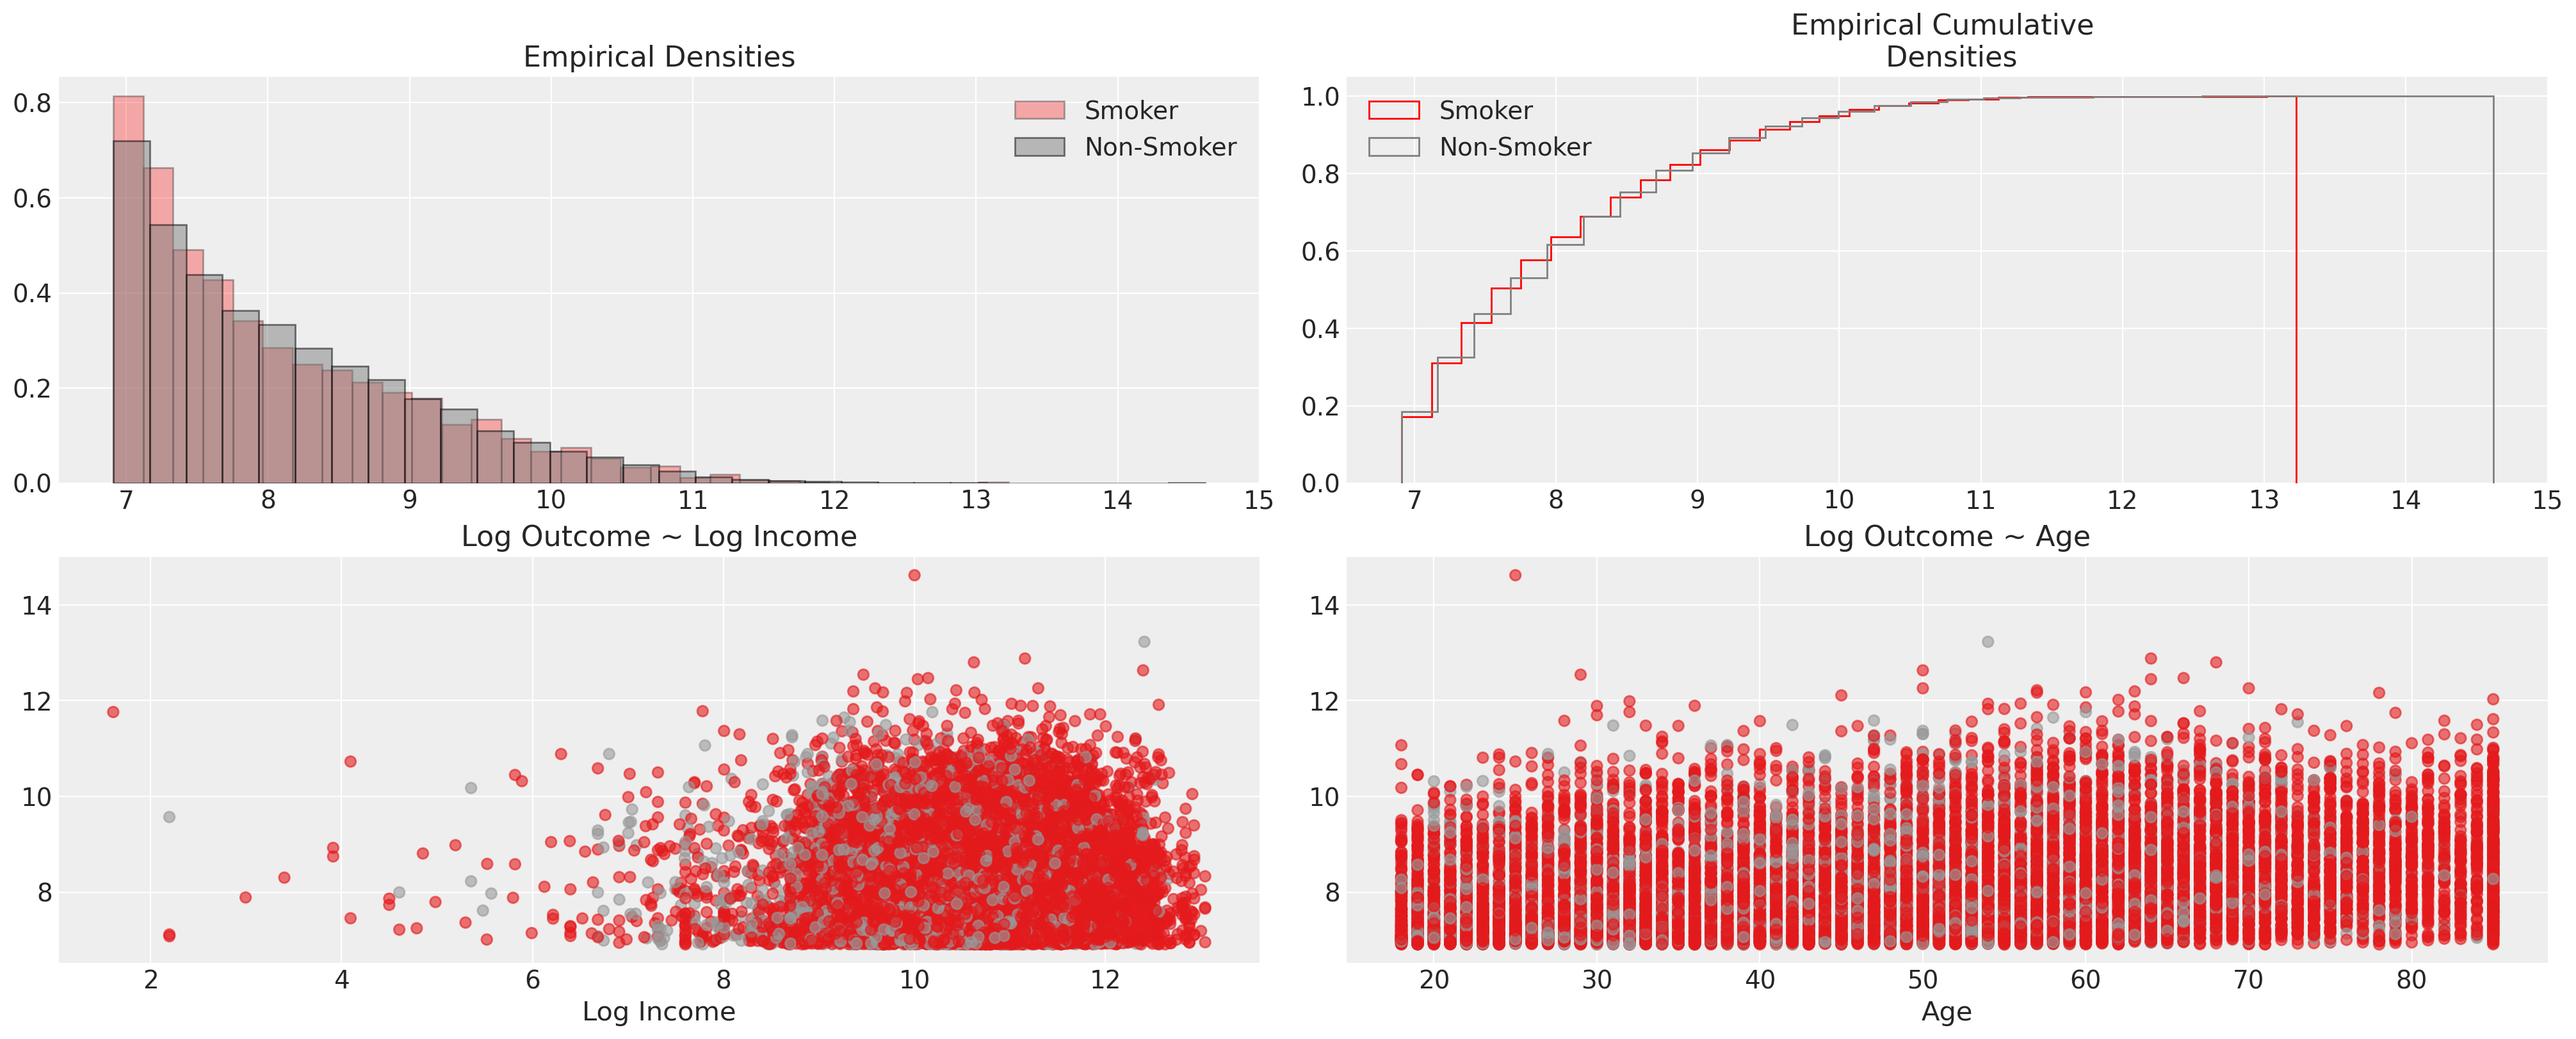

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
axs = axs.flatten()
axs[0].hist(
    df[df["smoke"] == 1]["log_y"],
    alpha=0.3,
    density=True,
    bins=30,
    label="Smoker",
    ec="black",
    color="red",
)
axs[0].hist(
    df[df["smoke"] == 0]["log_y"],
    alpha=0.5,
    density=True,
    bins=30,
    label="Non-Smoker",
    ec="black",
    color="grey",
)
axs[1].hist(
    df[df["smoke"] == 1]["log_y"],
    density=True,
    bins=30,
    cumulative=True,
    histtype="step",
    label="Smoker",
    color="red",
)
axs[1].hist(
    df[df["smoke"] == 0]["log_y"],
    density=True,
    bins=30,
    cumulative=True,
    histtype="step",
    label="Non-Smoker",
    color="grey",
)
axs[2].scatter(df["loginc"], df["log_y"], c=df["smoke"], cmap="Set1", alpha=0.6)
axs[2].set_xlabel("Log Income")
axs[3].scatter(df["age"], df["log_y"], c=df["smoke"], cmap="Set1", alpha=0.6)

axs[3].set_title("Log Outcome ~ Age")
axs[2].set_title("Log Outcome ~ Log Income")
axs[3].set_xlabel("Age")
axs[0].set_title("Empirical Densities")
axs[0].legend()
axs[1].legend()
axs[1].set_title("Empirical Cumulative \n Densities");

The plots would seem to confirm undifferentiated nature of the outcome across the two groups. With some hint of difference at the outer quantiles  of the distribution. 

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_5926/2759856003.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df.groupby("smoke")[["totexp"]]


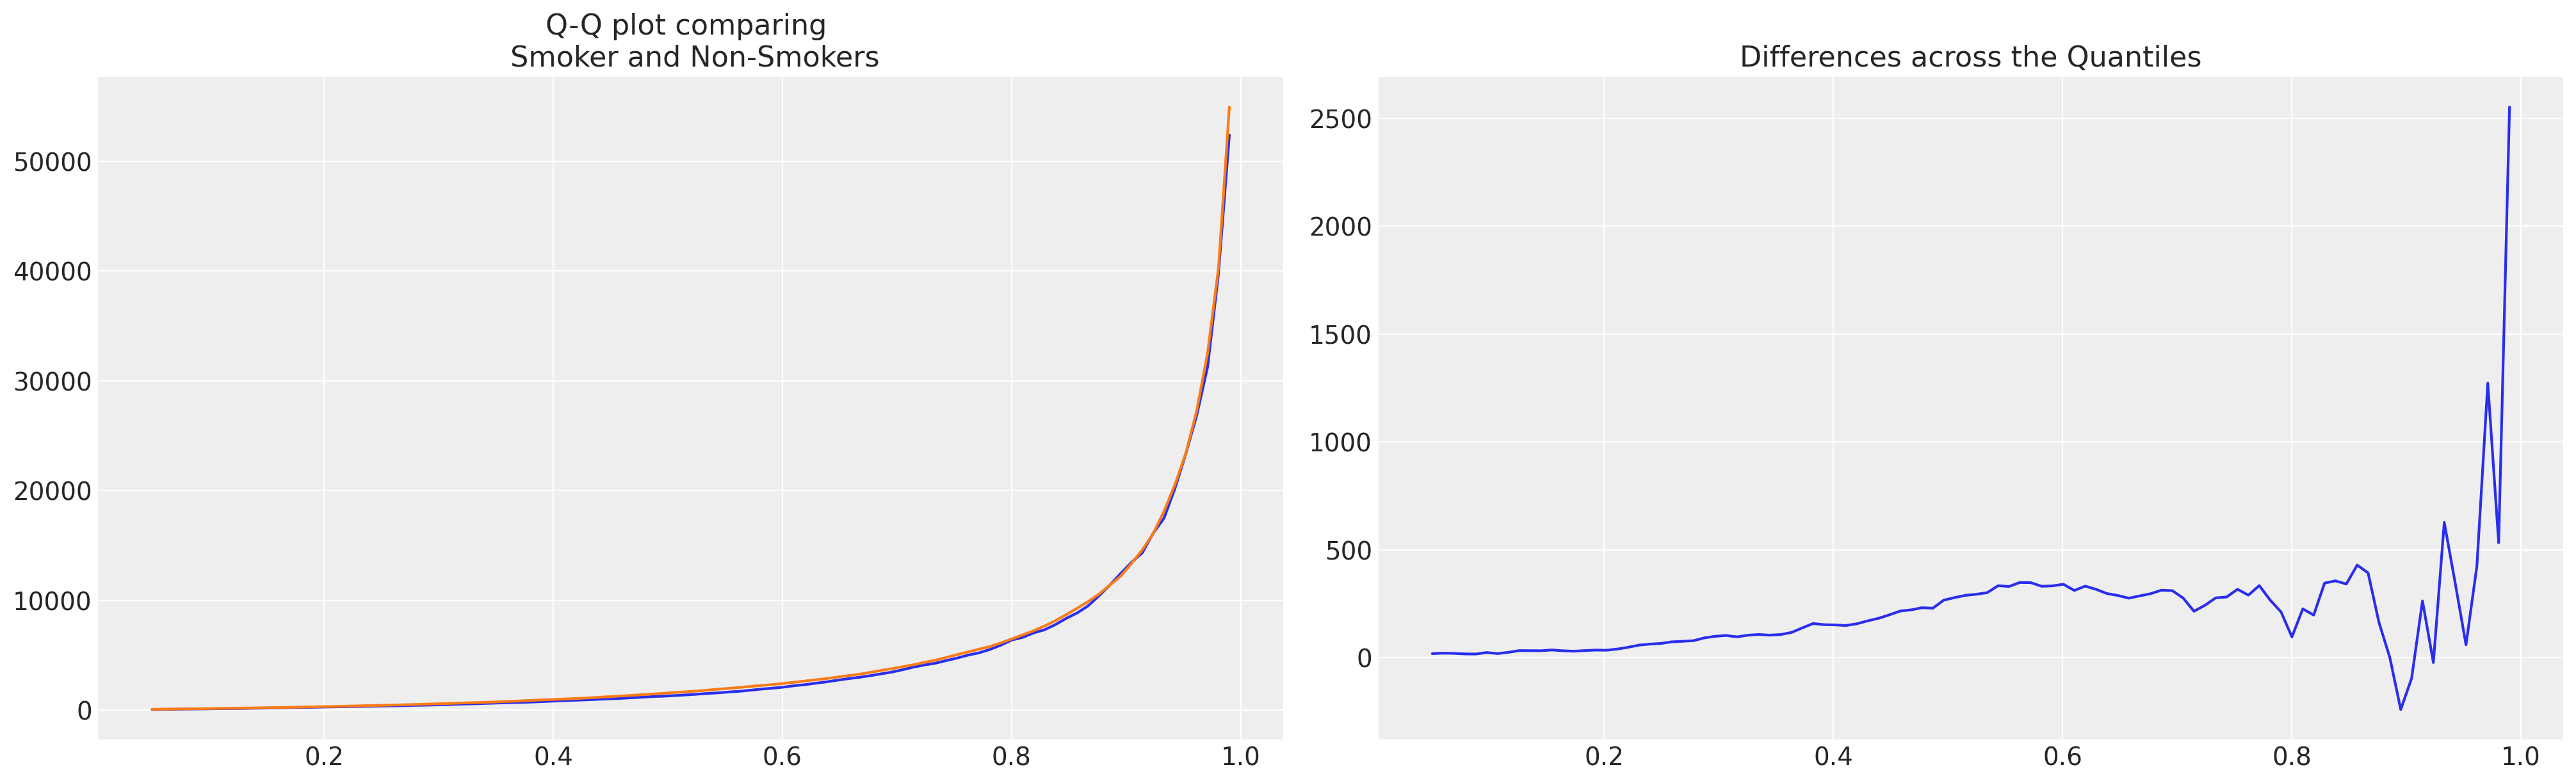

In [37]:
qs = np.linspace(0.05, 0.99, 100)
quantile_diff = (
    df.groupby("smoke")[["totexp"]]
    .quantile(qs)
    .reset_index()
    .pivot("level_1", "smoke", "totexp")
    .rename({0: "Non-Smoker", 1: "Smoker"}, axis=1)
    .assign(diff=lambda x: x["Non-Smoker"] - x["Smoker"])
    .reset_index()
    .rename({"level_1": "quantile"}, axis=1)
)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(quantile_diff["quantile"], quantile_diff["Smoker"])
axs[0].plot(quantile_diff["quantile"], quantile_diff["Non-Smoker"])
axs[0].set_title("Q-Q plot comparing \n Smoker and Non-Smokers")
axs[1].plot(quantile_diff["quantile"], quantile_diff["diff"])
axs[1].set_title("Differences across the Quantiles");

### What could possibly go Wrong?

In [39]:
dummies = pd.concat(
    [
        pd.get_dummies(df["seatbelt"], drop_first=True, prefix="seatbelt"),
        pd.get_dummies(df["marital"], drop_first=True, prefix="marital"),
        pd.get_dummies(df["race"], drop_first=True, prefix="race"),
        pd.get_dummies(df["sex"], drop_first=True, prefix="sex"),
        pd.get_dummies(df["phealth"], drop_first=True, prefix="phealth"),
    ],
    axis=1,
)
idx = df.sample(1000, random_state=100).index
X = pd.concat(
    [
        df[["age", "bmi"]],
        dummies,
    ],
    axis=1,
)
X = X.iloc[idx]
t = df.iloc[idx]["smoke"]
y = df.iloc[idx]["log_y"]
X

age   bmi  seatbelt_Always  seatbelt_Never  seatbelt_NoCar  \
2852    27  23.7                0               0               0   
13271   71  29.1                1               0               0   
6786    19  21.3                1               0               0   
15172   20  38.0                1               0               0   
10967   22  28.7                1               0               0   
...    ...   ...              ...             ...             ...   
5404    30  35.6                1               0               0   
8665    80  22.0                1               0               0   
3726    49  32.9                1               0               0   
6075    49  34.2                1               0               0   
795     53  28.2                1               0               0   

       seatbelt_Seldom  seatbelt_Sometimes  marital_Married  \
2852                 0                   0                1   
13271                0                   0                0   
6786                 0                   0                0   
15172                0                   0                0   
10967                0                   0                1   
...                ...                 ...              ...   
5404                 0                   0                1   
8665                 0                   0                0   
3726                 0                   0                1   
6075                 0                   0                1   
795                  0                   0                1   

       marital_Separated  marital_Widowed  race_Black  race_Indig  race_Multi  \
2852                   0                0           0           0           0   
13271                  0                1           1           0           0   
6786                   1                0           0           0           0   
15172                  1                0           1           0           0   
10967                  0                0           0           0           0   
...                  ...              ...         ...         ...         ...   
5404                   0                0           0           0           0   
8665                   0                1           0           0           0   
3726                   0                0           1           0           0   
6075                   0                0           0           0           0   
795                    0                0           0           0           0   

       race_PacificIslander  race_White  sex_Male  phealth_Fair  phealth_Good  \
2852                      0           1         1             0             0   
13271                     0           0         0             1             0   
6786                      0           1         0             0             0   
15172                     0           0         0             0             0   
10967                     0           1         0             0             0   
...                     ...         ...       ...           ...           ...   
5404                      0           1         1             0             1   
8665                      0           0         1             0             0   
3726                      0           0         1             0             1   
6075                      1           0         0             0             0   
795                       0           1         1             0             0   

       phealth_Poor  phealth_Very Good  
2852              0                  0  
13271             0                  0  
6786              0                  1  
15172             0                  1  
10967             0                  1  
...             ...                ...  
5404              0                  0  
8665              0                  0  
3726              0                  0  
6075              0                  1  
795               0     

In [40]:
m_ps_expend_bart, idata_expend_bart = make_propensity_model(
    X, t, bart=True, probit=True, samples=4000
)
m_ps_expend_logit, idata_expend_logit = make_propensity_model(X, t, bart=False, samples=1000)

Sampling: [mu, t_pred]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [t_pred]


Sampling: [b, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Sampling: [t_pred]


## Non-Parametric BART Model Propensity Model is mis-specified

The flexibility of the BART model fit is poorly calibrated to recover the average treatment effect. Let's evaluate the weighted outcome distributions under the robust IVPw estimate. 

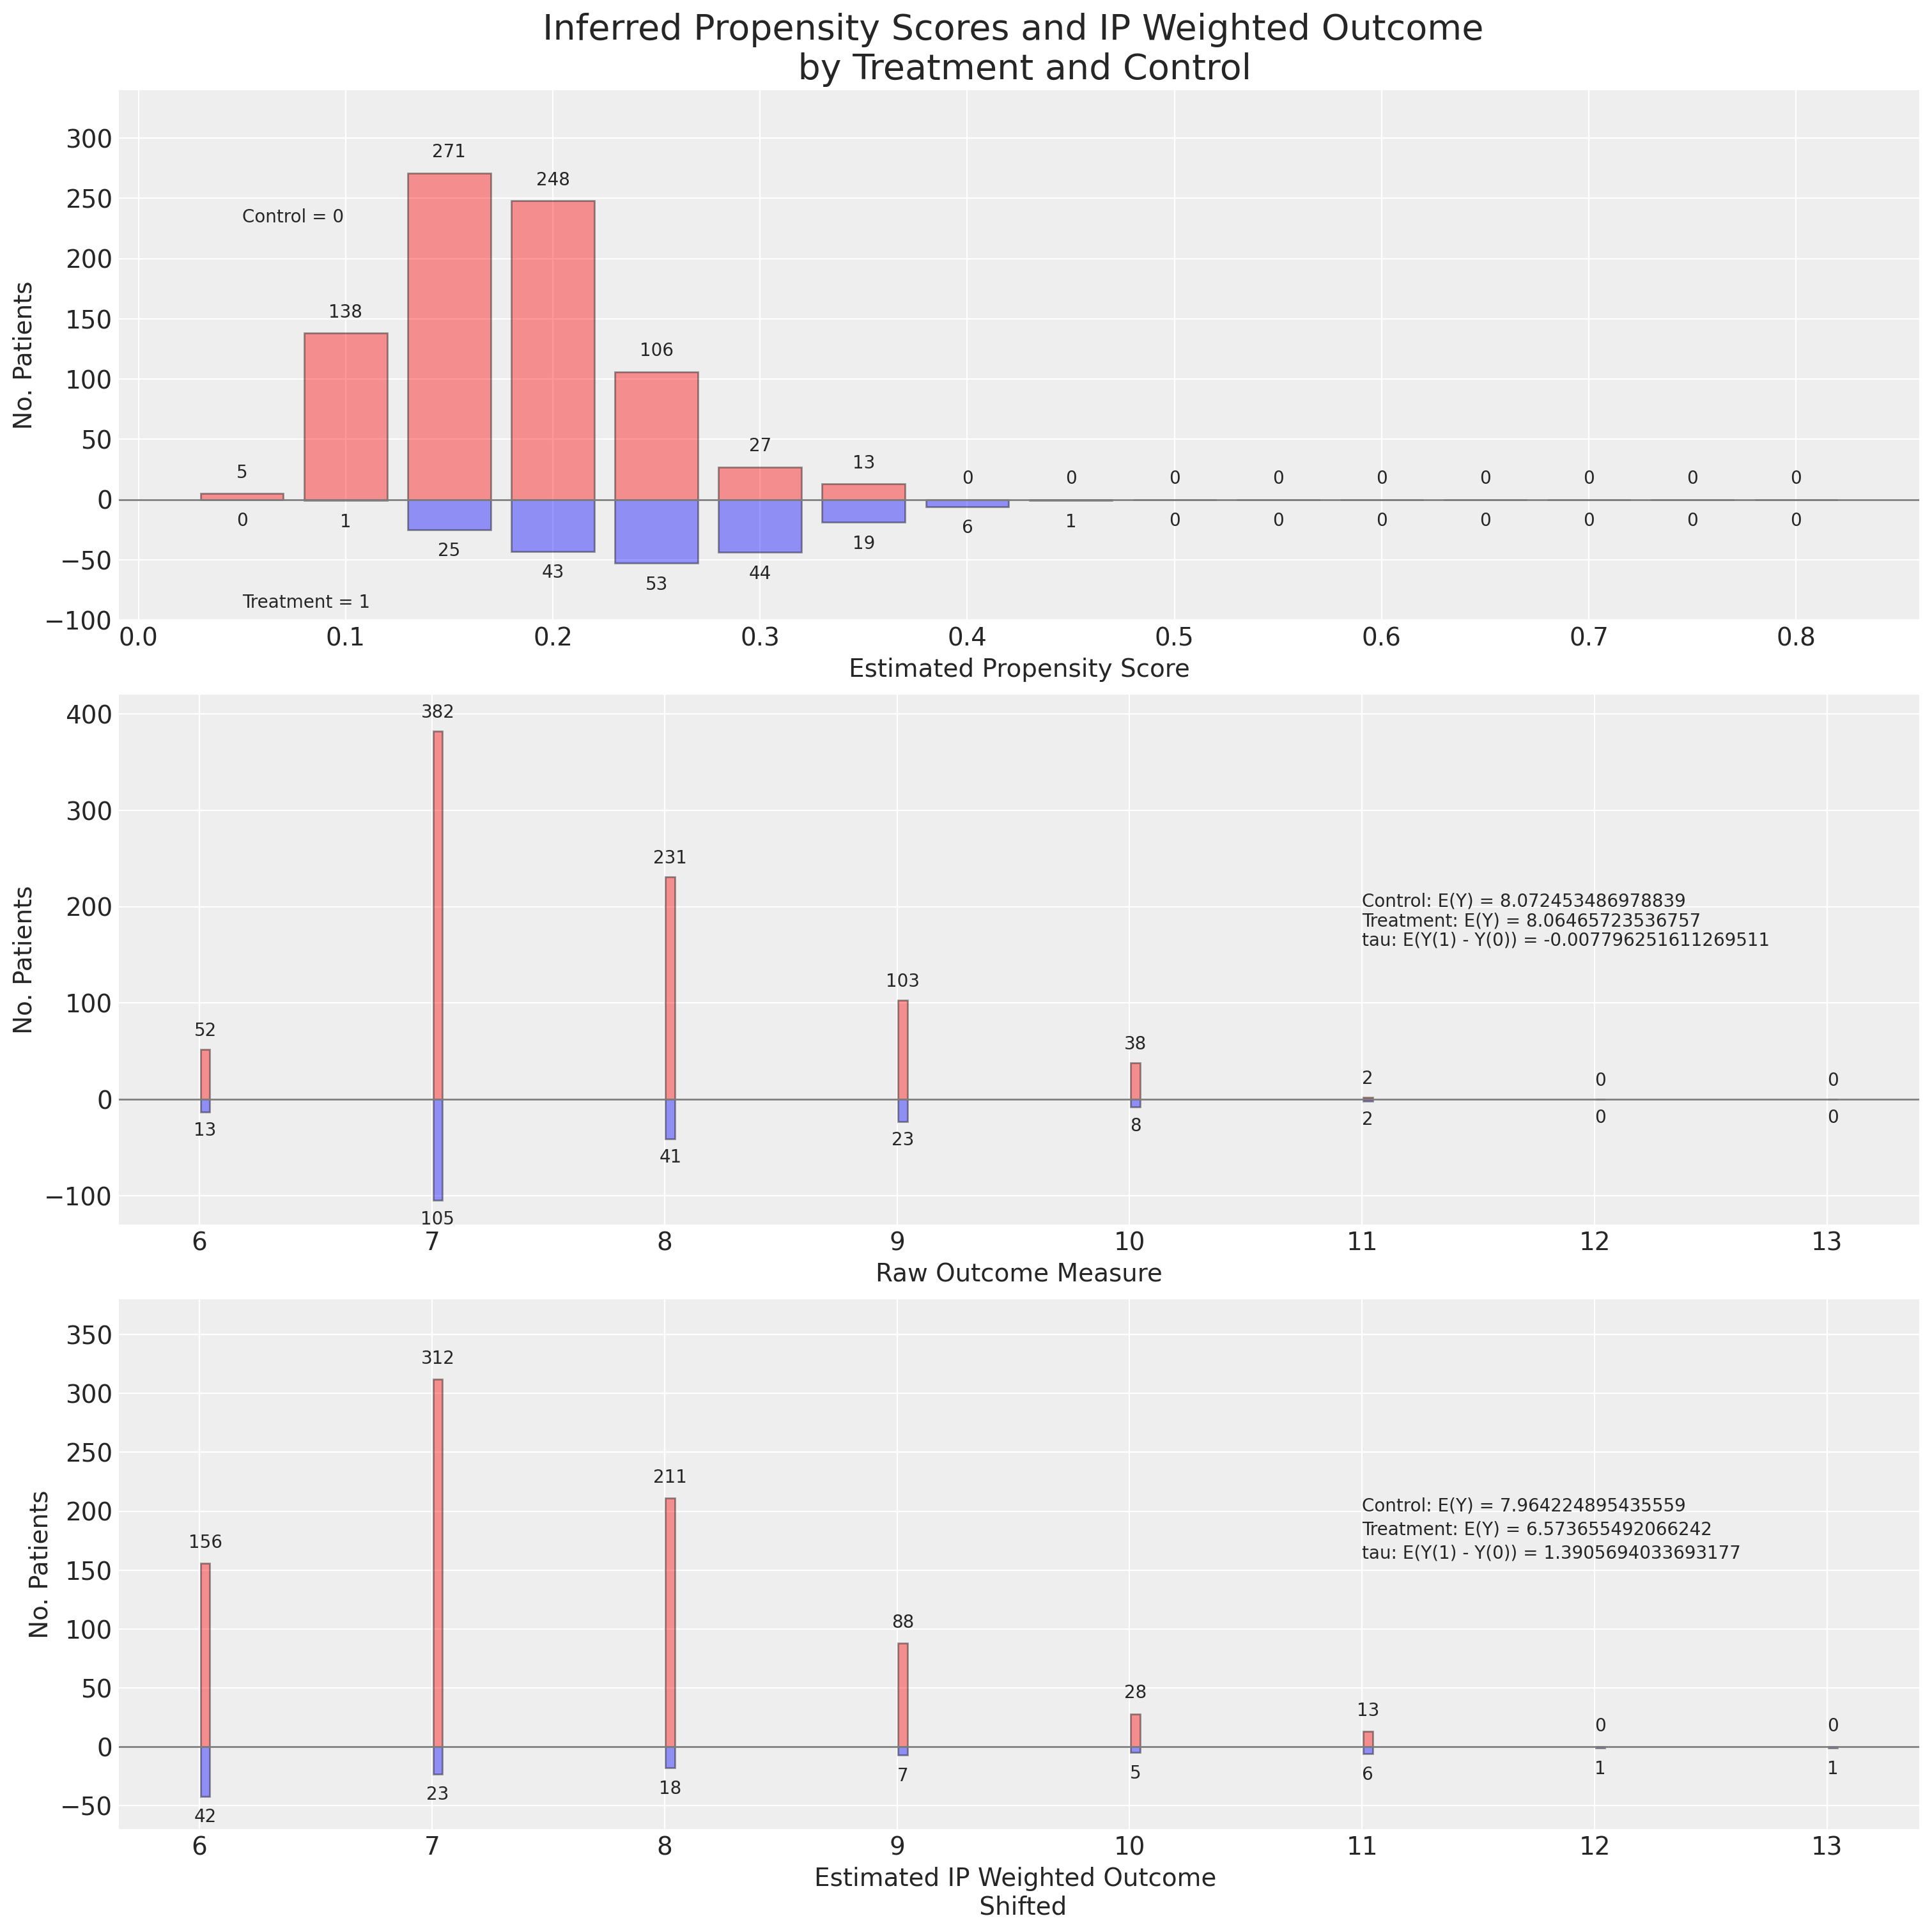

In [41]:
ps = idata_expend_bart["posterior"]["p"].mean(dim=("chain", "draw")).values
make_plot(
    X,
    idata_expend_bart,
    ylims=[(-100, 340), (-70, 380), (-130, 420)],
    lower_bins=np.arange(6, 15, 1),
    text_pos=(11, 200),
    method="robust",
    ps=ps,
)

This is a __disastrous__ result. Evaluated at the expected values of the posterior propensity score distribution the robust IPW estimator of ATE suggests a substantial difference in the treatment and control groups. What is going on?

What happens if we look at the posterior ATE distributions under different estimators?

In [42]:
qs = range(4000)
ate_dist = [get_ate(X, t, y, q, idata_expend_bart, method="doubly_robust") for q in qs]
ate_dist_df_dr = pd.DataFrame(ate_dist, columns=["ATE", "E(Y(1))", "E(Y(0))"])

ate_dist = [get_ate(X, t, y, q, idata_expend_bart, method="robust") for q in qs]
ate_dist_df_r = pd.DataFrame(ate_dist, columns=["ATE", "E(Y(1))", "E(Y(0))"])

ate_dist_df_dr.head()

ATE   E(Y(1))   E(Y(0))
0 -0.062842  8.101485  8.038643
1 -0.059726  8.093157  8.033431
2 -0.088472  8.126946  8.038474
3 -0.070936  8.109530  8.038594
4 -0.098595  8.138880  8.040285

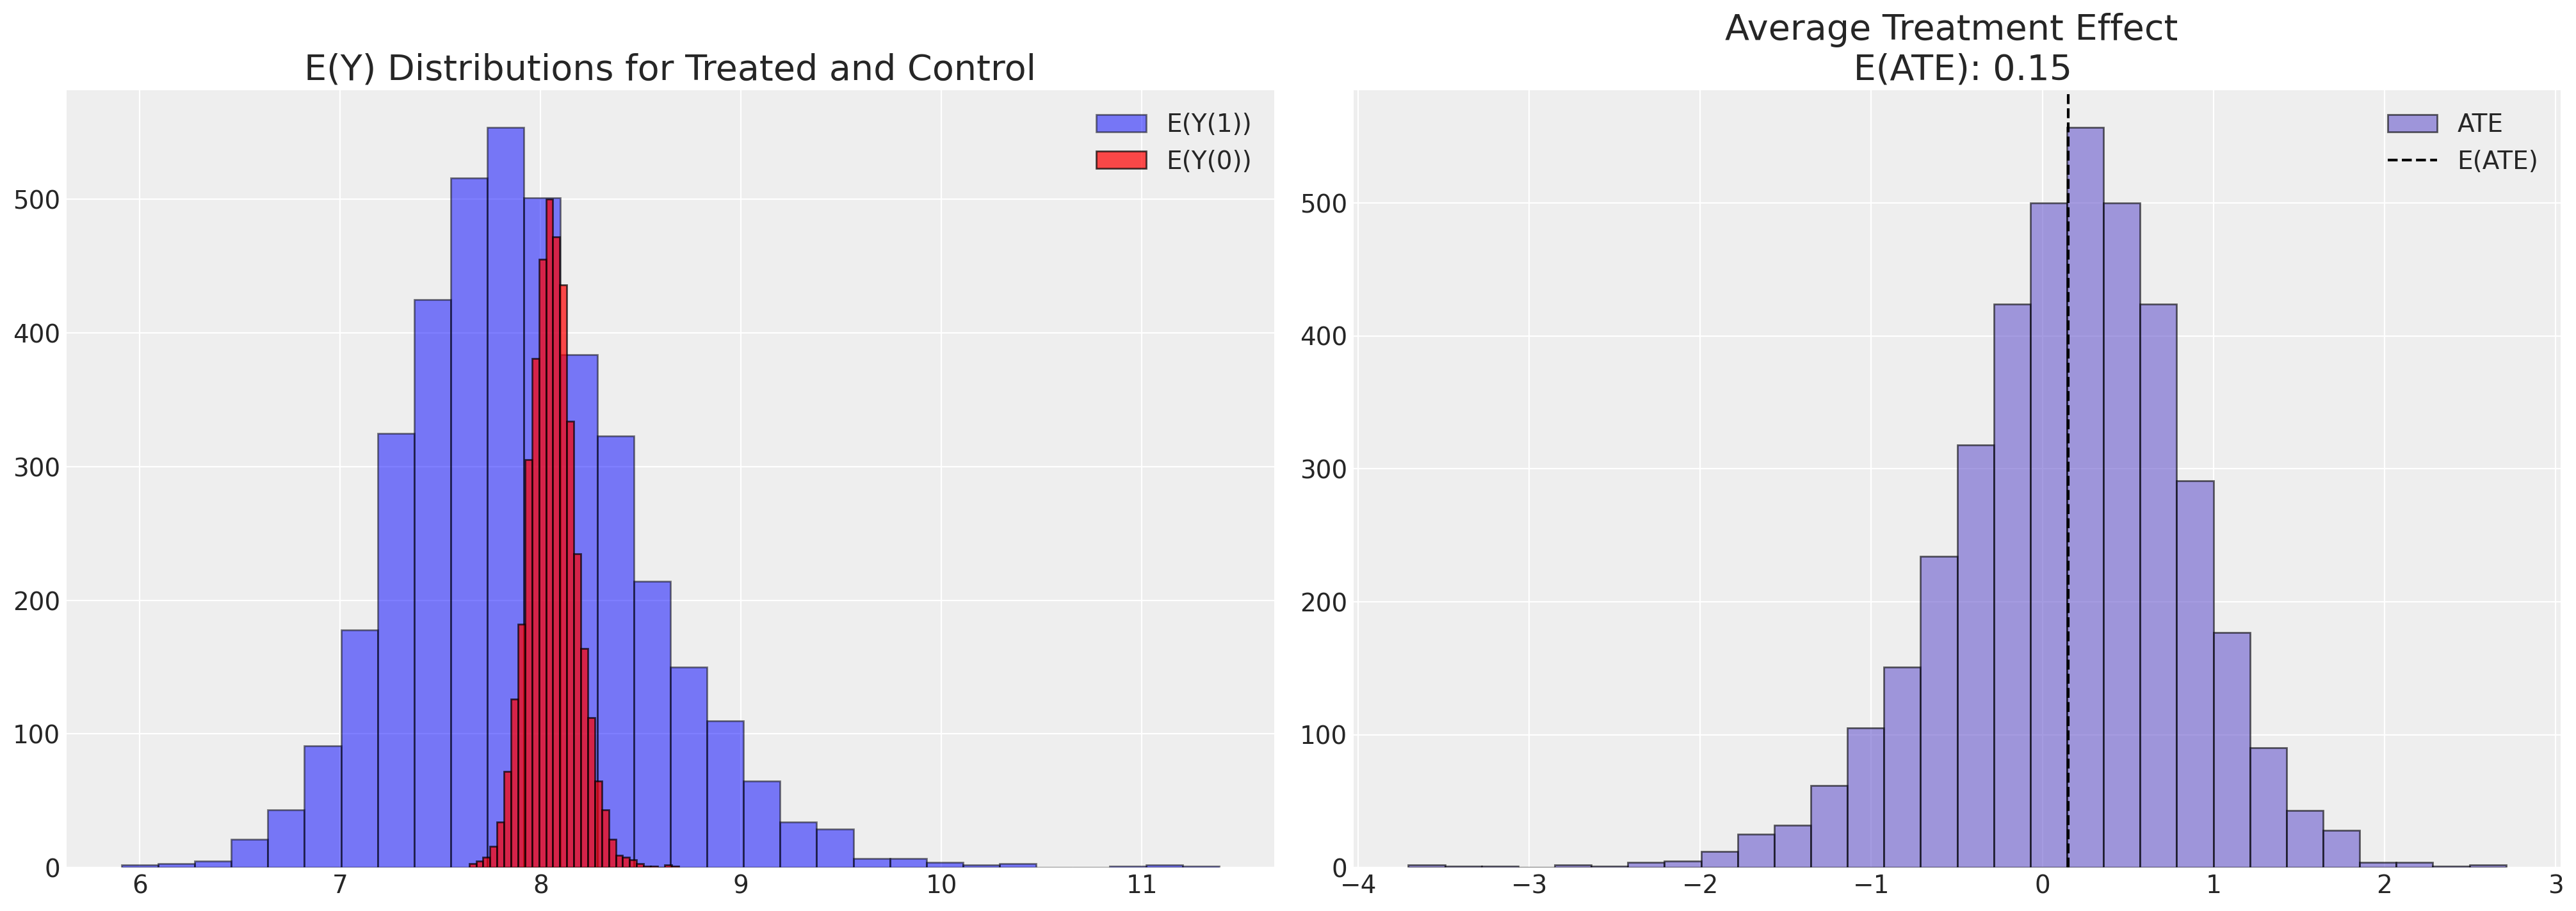

In [43]:
plot_ate(ate_dist_df_r)

Deriving ATE estimates across draws from the posterior distribution and averaging these seems to give a more sensible figure, but still inflated. If instead we use the doubly robust estimator we recover a much more sensible figure. 

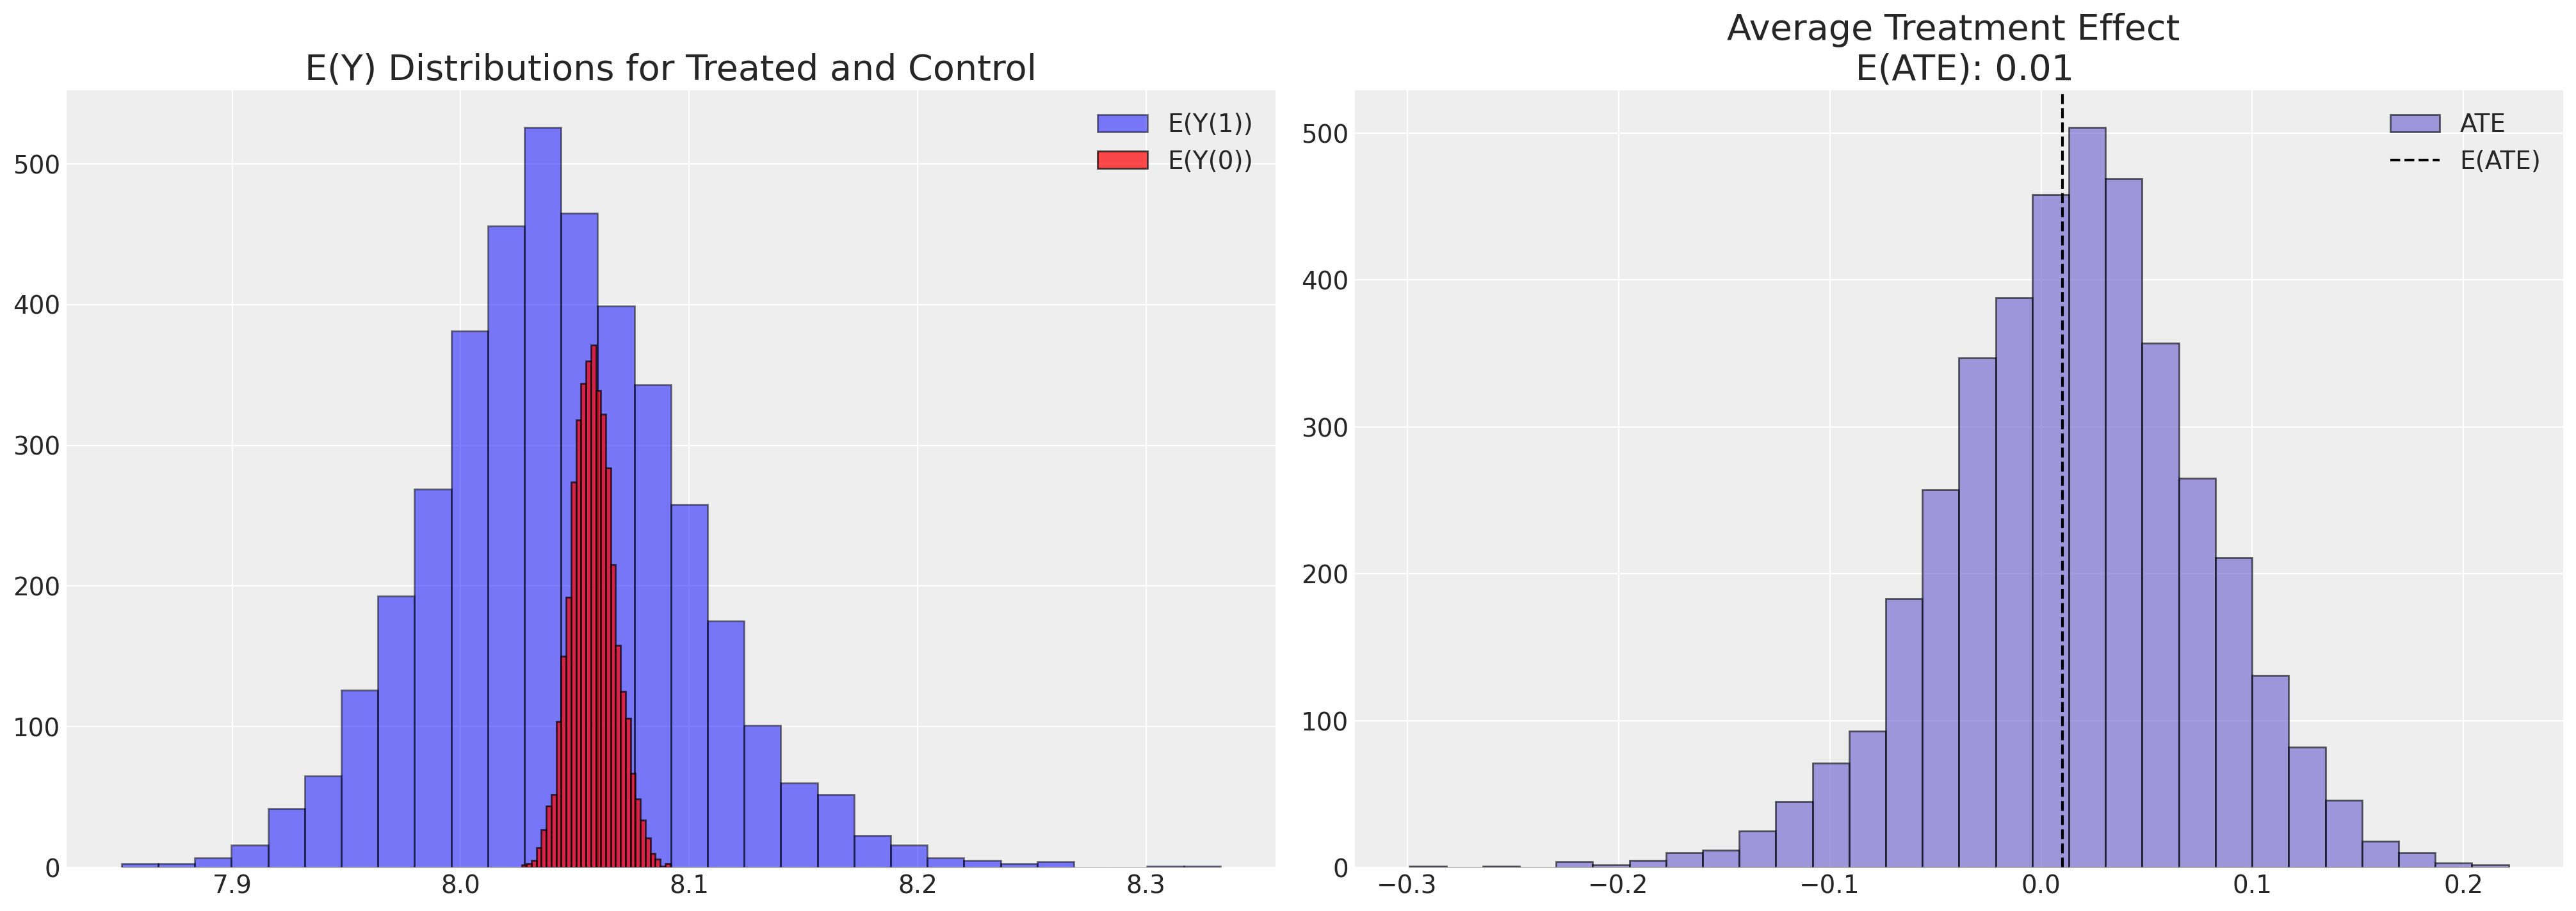

In [44]:
plot_ate(ate_dist_df_dr)

It's worth here expanding on the theory of doubly robust estimation. We showed above the code for implementing the compromise between the treatment assignment estimator and the response or outcome estimator. But why is this useful? Consider again the functional form of the doubly robust estimator.

$$ \hat{Y(1)} = \frac{1}{n} \sum_{0}^{N} \Bigg[ \frac{T(Y - m_{1}(X))}{p_{T}(X)} + m_{1}(X) \Bigg] $$

$$ \hat{Y(0)} = \frac{1}{n} \sum_{0}^{N} \Bigg[ \frac{(1-T)(Y - m_{0}(X))}{(1-p_{T}(X))} + m_{0}(X) \Bigg] $$

It is not immediately intuitive as to how these formulas effect a compromise between the outcome model and the treatment assignment model. But consider the extreme cases first imagine our model $m_{1}$ is a perfect fit to our outcome $Y$, then the numerator of the fraction is 0 and we end up with an average of the model predictions. Instead imagine model $m_{1}$ is mis-specified and we have some error $\epsilon > 0$ in the numerator. If the propensity score model is accurate then in the treated class our denominator should be high... say $\sim N(.9, .1)$, and as such the estimator adds a number close to $\epsilon$ back to the $m_{1}$ prediction. Similar reasoning goes through for the $Y(0)$ case. So as long as one of the two models is well-specified this estimator can recover accurate unbiased treatment effects.

## How does Regression Help?

We've just seen an example of how a mis-specfied machine learning model can wildly bias the causal estimates in a study. We've seen one means of fixing it, but how would things work out if we just tried simpler exploratory regression modelling?

In [45]:
model_ps_reg_expend, idata_ps_reg_expend = make_prop_reg_model(X, t, y, idata_expend_bart)

Sampling: [b, pred, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [pred]


In [46]:
az.summary(idata_ps_reg_expend, var_names=["b"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b[ps]      30.271  0.678  29.001   31.501      0.014    0.010    2482.0   
b[trt]      0.876  0.335   0.243    1.478      0.007    0.005    2336.0   
b[trt*ps]  -1.948  0.946  -3.807   -0.264      0.019    0.013    2535.0   

           ess_tail  r_hat  
b[ps]        2776.0    1.0  
b[trt]       2333.0    1.0  
b[trt*ps]    2660.0    1.0

This model is clearly too simple. It recovers only the biased estimate due to the mis-specified BART propensity model, but what if we just used the propensity as another feature in our covariate profile. Let it add precision, but fit the model we think actually reflects the causal story.

In [47]:
model_ps_reg_expend_h, idata_ps_reg_expend_h = make_prop_reg_model(
    X,
    t,
    y,
    idata_expend_bart,
    covariates=["phealth_Fair", "phealth_Good", "phealth_Poor", "phealth_Very Good"],
)

Sampling: [b, pred, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [pred]


In [48]:
az.summary(idata_ps_reg_expend_h, var_names=["b"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
b[ps]                 19.789  0.736  18.404   21.199      0.016    0.012   
b[trt]                 0.026  0.299  -0.559    0.576      0.005    0.004   
b[trt*ps]             -2.157  0.937  -3.947   -0.434      0.016    0.012   
b[phealth_Fair]        4.058  0.243   3.589    4.509      0.004    0.003   
b[phealth_Good]        3.914  0.207   3.504    4.287      0.004    0.003   
b[phealth_Poor]        3.871  0.364   3.209    4.556      0.005    0.004   
b[phealth_Very Good]   4.722  0.177   4.394    5.056      0.003    0.002   

                      ess_bulk  ess_tail  r_hat  
b[ps]                   2053.0    2489.0    1.0  
b[trt]                  3641.0    2992.0    1.0  
b[trt*ps]               3478.0    2875.0    1.0  
b[phealth_Fair]         2960.0    2890.0    1.0  
b[phealth_Good]         2696.0    2816.0    1.0  
b[phealth_Poor]         4401.0    3167.0    1.0  
b[phealth_Very Good]    3076.0    3063.0    1.0

This is much better and we can see that the propensity score feature in conjunction with the health factors to arrive at a sensible treatement effect estimate. This kind of finding echoes the lesson reported in Angrist and Pischke that:

> "Regression control for the right covariates does a reasonable job of eliminating selection effects..." pg 91 _Mostly Harmless Econometrics_ {cite:t}`angrist2008harmless`

So we're back to the question of the right controls. There is a no real way to avoid this burden. Neither machine learning nor double machine learning can serve as a pancea absent domain knowledge and careful attention to the problem at hand. This is never the inspiring message people want to hear, but it is unfortunately true. Regression helps with this because the unforgiving clarity of a coefficiencts table is a reminder that there is no substitute to measuring the right things well. 

## Double/Debiased Machine Learning and Frisch-Waugh-Lovell

To recap - we've seen two examples of causal inference with inverse probability weighted adjustments. We've seen when it works when the propensity score model is well-calibrated. We've seen when it fails and how the failure can be fixed. These are tools in our tool belt - apt for different problems, but come with the requirement that we think carefully about the data generating process and the type of appropriate covariates. 

In the case where the simple propensity modelling approach failed, we saw a data set in which our treatment assignment did not distinguish an average treatment effect. We also saw how if we augment our propensity based estimator we can improve the identification properties of the technique. Here we'll show another example of how propensity models can be combined with an insight from regression based modelling to take advantage of the flexible modelling possibilities offered by machine learning approaches to causal inference. In this secrion we draw heavily on the work of Matheus Facure, especially his book _Causal Inference in Python_ {cite:t}`facure2023causal`. 

### The Frisch-Waugh-Lovell Theorem

The idea of the theorem is that for any OLS fitted linear model with a focal parameter $\beta_{1}$ and the nuisance parameters $\gamma_{i}$ 

$$\hat{Y} = \beta_{0} + \beta_{1}X_{1} + \gamma_{1}N_{1} + ... + \gamma_{n}N_{n}  $$

We can retrieve the same values $\beta_{i}, \gamma_{i}$ in a two step procedure: 

- Regress $Y$ on the nuisance covariates i.e. $\hat{Y} = \gamma_{1}N_{1} + ... + \gamma_{n}N_{n} $
- Regress $X_{1}$ on the same nuisance terms i.e. $\hat{X_{1}} =  \gamma_{1}N_{1} + ... + \gamma_{n}N_{n}$
- Take the residuals $r(X) = X_{1} - \hat{X_{1}}$ and $r(Y) = Y - \hat{Y}$
- Fit the regression $r(Y) = \beta_{0} + \beta_{1}r(X)$ to find $\beta_{1}$

The idea of debiased machine learning is to replicate this exercise, but avail of the flexibility for machine learning models to estimate the two residual terms in the case where the focal variable of interest is our treatment variable. 

### Avoiding Overfitting with K-fold Cross Prediction

As we've seen above one of the concerns with the automatic regularisation effects of BART like tree based models is their tendency to over-fit to the seen data. Here we'll use K-fold cross validation to generate predictions on out of sample cuts of the data. This step is crucial to avoid the over-fitting of the model to the sample data and thereby avoiding the miscalibration effects we've seen above. 

In [144]:
dummies = pd.concat(
    [
        pd.get_dummies(df["seatbelt"], drop_first=True, prefix="seatbelt"),
        pd.get_dummies(df["marital"], drop_first=True, prefix="marital"),
        pd.get_dummies(df["race"], drop_first=True, prefix="race"),
        pd.get_dummies(df["sex"], drop_first=True, prefix="sex"),
        pd.get_dummies(df["phealth"], drop_first=True, prefix="phealth"),
    ],
    axis=1,
)
train_dfs = []
temp = pd.concat([df[["age", "bmi", "smoke"]], dummies], axis=1)

for i in range(5):
    idx = temp.sample(1000).index
    X = temp.iloc[idx].copy()
    t = df.iloc[idx]["smoke"]
    y = df.iloc[idx]["log_y"]
    train_dfs.append([X, t, y])
    remaining = [True if not i in idx else False for i in temp.index]
    temp = temp[remaining]
    temp.reset_index(inplace=True, drop=True)

### Applying Debiased ML Methods

Next we define the functions to fit and predict with the propensity score and outcome models. Because we're Bayesian we will record the posterior distribution of the residuals for both the outcome model and the propensity model. In both cases we'll use the baseline BART specification to avail of the flexibility of machine learning for accuracy. We then use the K-fold process to fit the model and predict the residuals on the out of sample fold. This allows us to extract the posterior distribution for ATE. 

In [145]:
def train_outcome_model(X, y):
    coords = {"coeffs": list(X.columns), "obs": range(len(X))}
    with pm.Model(coords=coords) as model:
        X_data = pm.MutableData("X", X)
        y_data = pm.MutableData("y_data", y)
        mu = pmb.BART("mu", X_data, y)
        sigma = pm.HalfNormal("sigma", 1)
        obs = pm.LogNormal("obs", mu, sigma, observed=y_data)
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(4000, progressbar=False))
        # idata.extend(pm.sample_posterior_predictive(idata))
    return model, idata


def train_propensity_model(X, t):
    coords = {"coeffs": list(X.columns), "obs_id": range(len(X))}
    with pm.Model(coords=coords) as model_ps:
        X_data = pm.MutableData("X", X)
        t_data = pm.MutableData("t_data", t)
        mu = pmb.BART("mu", X_data, t)
        p = pm.Deterministic("p", pm.math.invlogit(mu))
        t_pred = pm.Bernoulli("obs", p=p, observed=t_data)
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(4000, progressbar=False))
        # idata.extend(pm.sample_posterior_predictive(idata))
    return model_ps, idata


def cross_validate(train_dfs, test_idx):
    test = train_dfs[test_idx]
    test_X = test[0]
    test_t = test[1]
    test_y = test[2]
    train_X = pd.concat([train_dfs[i][0] for i in range(5) if i != test_idx])
    train_t = pd.concat([train_dfs[i][1] for i in range(5) if i != test_idx])
    train_y = pd.concat([train_dfs[i][2] for i in range(5) if i != test_idx])

    model, idata = train_outcome_model(train_X, train_y)
    with model:
        pm.set_data({"X": test_X, "y_data": test_y})
        idata_pred = pm.sample_posterior_predictive(idata)
    y_resid = idata_pred["posterior_predictive"]["obs"].stack(z=("chain", "draw")).T - test_y.values

    model_t, idata_t = train_propensity_model(train_X, train_t)
    with model_t:
        pm.set_data({"X": test_X, "t_data": test_t})
        idata_pred_t = pm.sample_posterior_predictive(idata_t)
    t_resid = (
        idata_pred_t["posterior_predictive"]["obs"].stack(z=("chain", "draw")).T - test_t.values
    )

    return y_resid, t_resid, idata_pred, idata_pred_t


y_resids = []
t_resids = []
model_fits = {}
for i in range(5):
    y_resid, t_resid, idata_pred, idata_pred_t = cross_validate(train_dfs, i)
    y_resids.append(y_resid)
    t_resids.append(t_resid)
    t_effects = []
    for j in range(1000):
        intercept = np.ones_like(1000)
        covariates = pd.DataFrame({"intercept": intercept, "t_resid": t_resid[j, :].values})
        m0 = sm.OLS(y_resid[j, :].values, covariates).fit()
        t_effects.append(m0.params["t_resid"])
    model_fits[i] = [m0, t_effects]
    print(f"Estimated Treament Effect in K-fold {i}: {np.mean(t_effects)}")

Sampling: [mu, obs, sigma]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, obs]


Sampling: [mu, obs]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 153 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, obs]


Estimated Treament Effect in K-fold 0: -0.00041185676810164717


Sampling: [mu, obs, sigma]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [mu, obs]


Sampling: [mu, obs]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 156 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, obs]


Estimated Treament Effect in K-fold 1: 8.234850087675296e-05


Sampling: [mu, obs, sigma]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, obs]


Sampling: [mu, obs]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 156 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, obs]


Estimated Treament Effect in K-fold 2: 0.00038293532965667733


Sampling: [mu, obs, sigma]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, obs]


Sampling: [mu, obs]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 155 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, obs]


Estimated Treament Effect in K-fold 3: 0.001916070034692669


Sampling: [mu, obs, sigma]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [mu, obs]


Sampling: [mu, obs]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 155 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, obs]


Estimated Treament Effect in K-fold 4: 0.0022809168210025286


In [171]:
y_resids_stacked = xr.concat(y_resids, dim=("obs_dim_2"))
t_resids_stacked = xr.concat(t_resids, dim=("obs_dim_2"))

y_resids_stacked

<xarray.DataArray 'obs' (z: 16000, obs_dim_2: 5000)>
array([[-1.03604716, -0.00718648,  1.76448141, ...,  4.04713985,
         4.62560433, -0.3264046 ],
       [ 1.29750722,  1.53269392,  0.15388084, ...,  0.91760886,
        -0.87745185, -0.00645966],
       [ 1.76456348, -1.09735066,  2.37605809, ...,  2.17167555,
         0.17818353, -0.40580509],
       ...,
       [ 1.25820871,  1.05844397,  1.33049281, ...,  1.4758568 ,
         0.43044705, -1.13039615],
       [ 1.13526522,  0.42984957,  0.94346693, ..., -0.40771383,
         0.29269876,  0.53666609],
       [ 1.86899069,  1.27257406,  0.8043687 , ...,  0.43305539,
         0.93103628,  0.99817269]])
Coordinates:
  * obs_dim_2  (obs_dim_2) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * z          (z) object MultiIndex
  * chain      (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3 3
  * draw       (z) int64 0 1 2 3 4 5 6 7 ... 3993 3994 3995 3996 3997 3998 3999

In [173]:
t_effects = []
for i in range(16000):
    intercept = np.ones_like(5000)
    covariates = pd.DataFrame({"intercept": intercept, "t_resid": t_resids_stacked[i, :].values})
    m0 = sm.OLS(y_resids_stacked[i, :].values, covariates).fit()
    t_effects.append(m0.params["t_resid"])

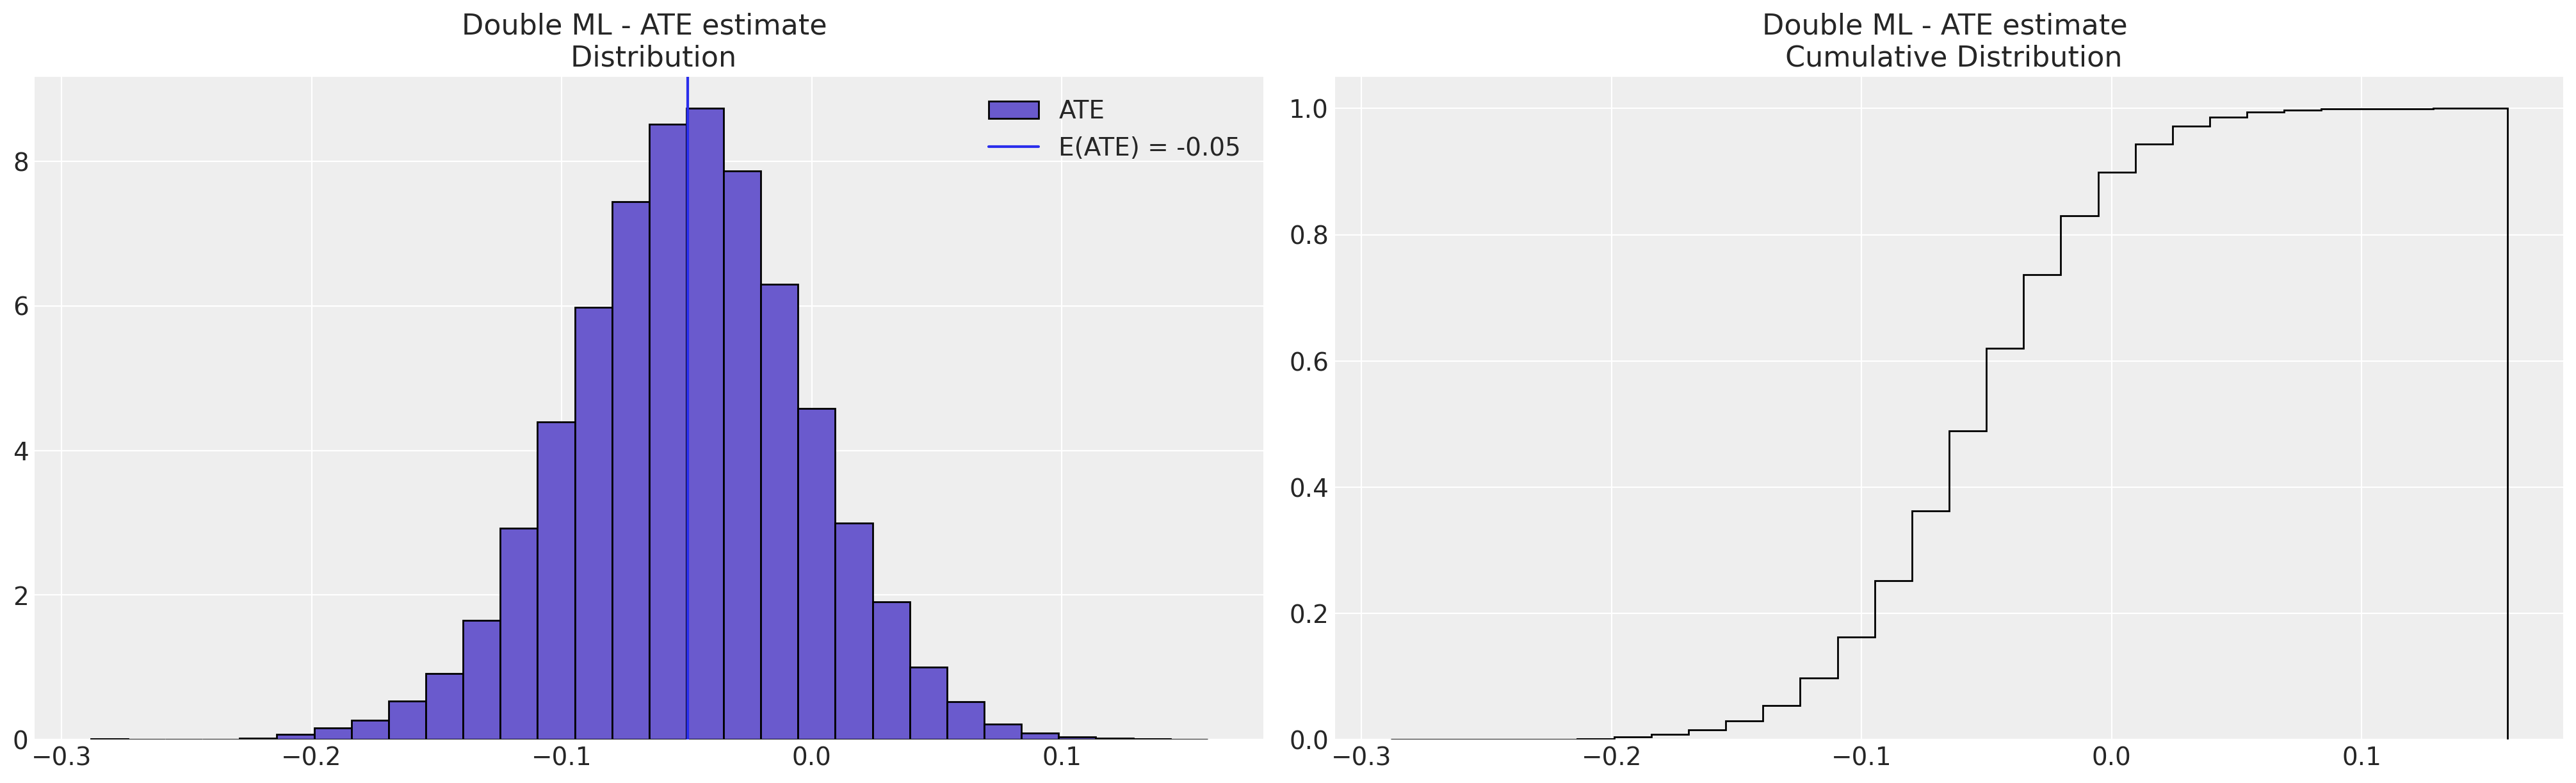

In [174]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
axs[0].hist(t_effects, bins=30, ec="black", color="slateblue", label="ATE", density=True)
axs[1].hist(
    t_effects,
    bins=30,
    ec="black",
    color="slateblue",
    cumulative=True,
    histtype="step",
    density=True,
)
axs[0].set_title("Double ML - ATE estimate \n Distribution")
axs[1].set_title("Double ML - ATE estimate \n Cumulative Distribution")
ate = np.mean(t_effects)
axs[0].axvline(ate, label=f"E(ATE) = {np.round(ate, 2)}")

axs[0].legend();

We can see here how the technique of debiased machine learning has helped to alleviate some of the miscalibrated effects of naively fitting the BART model to the propensity score estimation task. 

## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in January 2024 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Jan 01 2024

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

arviz     : 0.15.1
matplotlib: 3.7.1
pymc      : 5.3.0
pandas    : 1.5.3
numpy     : 1.23.5

Watermark: 2.3.1



:::{include} ../page_footer.md
:::